# Modkit dmr
# Day 6 data
## Use my Filtered Reads

In [1]:
from datetime import datetime

def current_time():
    """Returns the current date and time as a formatted string."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S") 

print("Current Date and Time:", current_time())

Current Date and Time: 2025-11-21 10:18:42


Based on:
https://nanoporetech.github.io/modkit/intro_dmr.html#perform-differential-methylation-scoring

Select kernal: dimelo_v2_modkit_parsing

Preparing the input data
The inputs to all modkit dmr commands are two or more bedMethyl files (created by modkit pileup) that have been compressed with bgzip and indexed with tabix. An example of how to generate the input data is shown below:


ref=grch38.fasta
threads=32

norm=normal_sample.bam
norm_pileup=normal_pileup.bed

modkit pileup ${norm} ${norm_pileup} \
  --cpg \
  --ref ${ref} \
  --threads ${threads} \
  --log-filepath log.txt

bgzip -k ${norm_pileup}
tabix -p bed ${norm_pileup}.gz

# pileup and compression can also be done in one step
tumor=tumor_sample.bam
tumor_pileup=tumor_pileup.bed.gz

modkit pileup ${tumor} - \
  --cpg \
  --ref ${ref} \
  --threads ${threads} \
  --log-filepath log.txt | ${bgzip} -c > ${tumor_pileup}

tabix -p bed ${tumor_pileup}

In [2]:
%%bash
echo "hello"

hello


# Use the NEW modkit latest installed version in ipython kernel modkit_new

In [3]:
# ! python3 -m ipykernel install --user --name=modkit_new --display-name "modkit_new Python"
# ! which modkit

In [4]:
import os
os.environ["PATH"] = "/home/michalula/.cargo/bin:" + os.environ["PATH"]
! which modkit
! modkit --version

/home/michalula/.cargo/bin/modkit


modkit 0.5.1


In [5]:
# ! modkit

In [6]:
! modkit --version 

modkit 0.5.1


In [7]:
import os
import pandas as pd

def load_pileup_bed(bed_path):
    # bed_path = existing[0]
    print("Reading bedMethyl file:", bed_path)

    # bedMethyl column names (18 columns as provided)
    colnames = [
        "chrom", "start", "end", "mod_code", "score", "strand",
        "start2", "end2", "color",
        "Nvalid_cov", "percent_modified", "Nmod", "Ncanonical",
        "Nother_mod", "Ndelete", "Nfail", "Ndiff", "Nnocall"
    ]

    # Configure dtypes where reasonable
    dtypes = {
        "chrom": str,
        "start": "Int64",
        "end": "Int64",
        "mod_code": str,
        "score": "Int64",
        "strand": str,
        "start2": "Int64",
        "end2": "Int64",
        "color": str,
        "Nvalid_cov": "Int64",
        "percent_modified": float,
        "Nmod": "Int64",
        "Ncanonical": "Int64",
        "Nother_mod": "Int64",
        "Ndelete": "Int64",
        "Nfail": "Int64",
        "Ndiff": "Int64",
        "Nnocall": "Int64"
    }

    compression = "gzip" if bed_path.endswith(".gz") else None

    # Read file (headerless BED-like table). If file has extra columns, keep them with automatic numeric conversion below.
    df = pd.read_csv(
        bed_path,
        sep="\t",
        header=None,
        comment="#",
        names=colnames,
        dtype=dtypes,
        compression=compression,
        engine="python",
        na_values=[".", "NA", ""],
        keep_default_na=True
    )

    # If file contained more than 18 columns, pandas assigned remaining data to extra columns named like col_18, col_19...
    # Ensure numeric conversion for numeric-like columns
    for c in df.columns:
        if df[c].dtype == object:
            # try safe numeric conversion where appropriate
            try:
                df[c] = pd.to_numeric(df[c], errors="ignore")
            except Exception:
                pass

    print("Loaded DataFrame shape:", df.shape)
    display(df.head())
    return df


In [8]:
import os
from IPython.display import display, HTML
from plotly import express as px
from plotly import graph_objects as go

# ! python3 -m pip install plotly
# ! python3 -m pip install matplotlib
# ! python3 -m pip install nbformat>=4.2.0

def plot_pileup_roi_df(df_roi, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    # ensure numeric types for plotting
    df_roi['pos'] = df_roi['start'].astype(int)
    df_roi['percent_modified'] = df_roi['percent_modified'].astype(float)
    df_roi['Nvalid_cov'] = df_roi['Nvalid_cov'].astype(int)
    df_roi['Nmod'] = df_roi['Nmod'].astype(int)
    df_roi['Ncanonical'] = df_roi['Ncanonical'].astype(int)

    # Scatter: genomic position vs percent modified (point size = coverage)
    fig1 = px.scatter(
        df_roi,
        x='pos',
        y='percent_modified',
        color='strand',
        size='Nvalid_cov',
        hover_data=['Nvalid_cov','Nmod','Ncanonical','Nother_mod','Nnocall'],
        title='Percent modified across ROI (size = Nvalid_cov)',
        height=500
    )
    fig1.update_layout(xaxis_title='Genomic position (start)', yaxis_title='Percent modified')
    fig1.show()
    # fig1.write_html(os.path.join(out_dir, "roi_percent_modified_scatter.html"), include_plotlyjs='cdn')

    # Histogram: coverage distribution
    fig2 = px.histogram(
        df_roi,
        x='Nvalid_cov',
        nbins=40,
        title='Distribution of Nvalid_cov (coverage) in ROI',
        height=400
    )
    fig2.update_layout(xaxis_title='Nvalid_cov', yaxis_title='Count')
    fig2.show()
    # fig2.write_html(os.path.join(out_dir, "roi_nvalidcov_hist.html"), include_plotlyjs='cdn')

    # Bar: top sites by percent_modified showing Nmod vs Ncanonical (stacked)
    topn = 30
    df_top = df_roi.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    fig3 = go.Figure()
    fig3.add_trace(go.Bar(name='Nmod', x=df_top['label'], y=df_top['Nmod']))
    fig3.add_trace(go.Bar(name='Ncanonical', x=df_top['label'], y=df_top['Ncanonical']))
    fig3.update_layout(barmode='stack', title=f'Sorted Top {topn} sites by percent_modified (stacked Nmod / Ncanonical)',
                    xaxis_title='position:strand', yaxis_title='reads', height=520)
    fig3.show()
    # fig3.write_html(os.path.join(out_dir, "roi_top_sites_stacked_counts.html"), include_plotlyjs='cdn')

    # Print simple summaries
    print("ROI rows:", df_roi.shape[0])
    print("Percent modified: median={:.2f}, mean={:.2f}".format(df_roi['percent_modified'].median(), df_roi['percent_modified'].mean()))
    print("Coverage (Nvalid_cov): min={}, median={}, max={}".format(df_roi['Nvalid_cov'].min(), df_roi['Nvalid_cov'].median(), df_roi['Nvalid_cov'].max()))

    # Display first rows table for quick inspection
    display(HTML(df_roi.head(20).to_html(index=False)))


    # Bar: top sites by percent_modified showing Nmod vs Ncanonical (stacked)
    topn = df_roi.shape[0]
    # df_top = df_roi.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_roi.copy() #.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    fig3 = go.Figure()
    fig3.add_trace(go.Bar(name='Nmod', x=df_top['label'], y=df_top['Nmod']))
    fig3.add_trace(go.Bar(name='Ncanonical', x=df_top['label'], y=df_top['Ncanonical']))
    fig3.update_layout(barmode='stack', title=f'All {topn} CpG sites by percent_modified (stacked Nmod / Ncanonical) [ordered=not s]',
                    xaxis_title='position:strand', yaxis_title='reads', height=520)
    fig3.show()
    # fig3.write_html(os.path.join(out_dir, "roi_top_sites_stacked_counts.html"), include_plotlyjs='cdn')

    # Bar: top sites by percent_modified showing Nmod vs Ncanonical (stacked, NOT SORTED)
    topn = df_roi.shape[0]
    df_top = df_roi.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    fig3 = go.Figure()
    fig3.add_trace(go.Bar(name='Nmod', x=df_top['label'], y=df_top['Nmod']))
    fig3.add_trace(go.Bar(name='Ncanonical', x=df_top['label'], y=df_top['Ncanonical']))
    fig3.update_layout(barmode='stack', title=f'Sorted Top {topn} sites by percent_modified (stacked Nmod / Ncanonical)',
                    xaxis_title='position:strand', yaxis_title='reads', height=520)
    fig3.show()
    # fig3.write_html(os.path.join(out_dir, "roi_top_sites_stacked_counts.html"), include_plotlyjs='cdn')

    # Print simple summaries
    print("ROI rows:", df_roi.shape[0])
    print("Percent modified: median={:.2f}, mean={:.2f}".format(df_roi['percent_modified'].median(), df_roi['percent_modified'].mean()))
    print("Coverage (Nvalid_cov): min={}, median={}, max={}".format(df_roi['Nvalid_cov'].min(), df_roi['Nvalid_cov'].median(), df_roi['Nvalid_cov'].max()))

    # Display first rows table for quick inspection
    display(HTML(df_roi.head(20).to_html(index=False)))

    # Bar: top sites by percent_modified showing Nmod vs Ncanonical (stacked) percentages
    topn = 30
    df_top = df_roi.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    df_top = df_top.assign(Ntotal=df_top['Nmod'] + df_top['Ncanonical'])
    df_top = df_top.assign(Nmod_perc=(df_top['Nmod'] / df_top['Ntotal']) * 100)
    df_top = df_top.assign(Ncanonical_perc=(df_top['Ncanonical'] / df_top['Ntotal']) * 100)
    fig4 = go.Figure()
    fig4.add_trace(go.Bar(name='Nmod %', x=df_top['label'], y=df_top['Nmod_perc']))
    fig4.add_trace(go.Bar(name='Ncanonical %', x=df_top['label'], y=df_top['Ncanonical_perc']))
    fig4.update_layout(barmode='stack', title=f'Top {topn} sites by percent_modified (stacked Nmod % / Ncanonical %)',
                    xaxis_title='position:strand', yaxis_title='percentage', height=520)
    fig4.show()
    # fig4.write_html(os.path.join(out_dir, "roi_top_sites_stacked_percentage.html"), include_plotlyjs='cdn')     


    # Bar: top sites by percent_modified showing Nmod vs Ncanonical (stacked) percentages
    topn = 277
    df_top = df_roi.sort_values('percent_modified', ascending=False).head(topn).copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    df_top = df_top.assign(Ntotal=df_top['Nmod'] + df_top['Ncanonical'])
    df_top = df_top.assign(Nmod_perc=(df_top['Nmod'] / df_top['Ntotal']) * 100)
    df_top = df_top.assign(Ncanonical_perc=(df_top['Ncanonical'] / df_top['Ntotal']) * 100)
    fig4 = go.Figure()
    fig4.add_trace(go.Bar(name='Nmod %', x=df_top['label'], y=df_top['Nmod_perc']))
    fig4.add_trace(go.Bar(name='Ncanonical %', x=df_top['label'], y=df_top['Ncanonical_perc']))
    fig4.update_layout(barmode='stack', title=f'Top {topn} sites by percent_modified (stacked Nmod % / Ncanonical %)',
                    xaxis_title='position:strand', yaxis_title='percentage', height=520)
    fig4.show()
    # fig4.write_html(os.path.join(out_dir, "roi_top_sites_stacked_percentage.html"), include_plotlyjs='cdn')     

    # Bar: Unsorted sites by percent_modified showing Nmod vs Ncanonical (stacked) percentages
    df_top = df_roi.copy()
    df_top = df_top.assign(label=df_top['pos'].astype(str) + ":" + df_top['strand'])
    df_top = df_top.assign(Ntotal=df_top['Nmod'] + df_top['Ncanonical'])
    df_top = df_top.assign(Nmod_perc=(df_top['Nmod'] / df_top['Ntotal']) * 100)
    df_top = df_top.assign(Ncanonical_perc=(df_top['Ncanonical'] / df_top['Ntotal']) * 100)
    fig5 = go.Figure()
    fig5.add_trace(go.Bar(name='Nmod %', x=df_top['label'], y=df_top['Nmod_perc']))
    fig5.add_trace(go.Bar(name='Ncanonical %', x=df_top['label'], y=df_top['Ncanonical_perc']))
    fig5.update_layout(barmode='stack', title=f'All sites by percent_modified (stacked Nmod % / Ncanonical %)',
                    xaxis_title='position:strand', yaxis_title='percentage', height=520)
    fig5.show()
    # fig5.write_html(os.path.join(out_dir, "roi_all_sites_stacked_percentage.html"), include_plotlyjs='cdn')    


    return df_top



In [9]:
! ls /home/michalula/data/ref_genomes/t2t_v2_0/

chm13v2.0.fa	  chm13v2.0.fa.fai		   haplotype_vcf
chm13v2.0.fa.amb  chm13v2.0.fa.pac		   up_chm13v2.0.fasta
chm13v2.0.fa.ann  chm13v2.0.fa.sa		   up_chm13v2.0.fasta.fai
chm13v2.0.fa.bwt  convert_to_uppercase_fasta.bash


# Pileups 
## for CRISPRoff filtered data for Day 6

In [11]:
! ls /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-29_units_combined_numFWD802_numRVS1480.npy

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-29_units_combined_numFWD802_numRVS1480.npy


In [12]:
! ls /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/

CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_avgBaseQ10_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-24_units_combined_numFWD1098_numRVS2130.npy
CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_avgBaseQ20_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-13_units_combined_numFWD659_numRVS1149.npy
CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_avgBaseQ20_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-24_units_combined_numFWD659_numRVS1149.npy
CG_137_padded_reads_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-29_units_combined_numFWD802_numRVS1480.npy
CG_137_padded_reads_day6_CRoff_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_avgBaseQ10_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-27_units_combined_numFWD1087_numRVS2083.npy

In [ ]:
%%bash
date_today="20251110"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
mkdir ${pileup_data_folder_path}

# mC > 99.5% = 0995 filtered 
# filtered_CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# mC >70% = 07 filtered 
# filtered_CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# Pre-filtered mC > 70%::
CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"


# use full data unfiltered .BAM file
# data_folder_path="/home/michalula/data/cas9_nanopore/data/20250908_nCATs_T_CRoff_Day_6/5mCG/to_t2t_v2_0/"
# CROFF_day6_bam=${data_folder_path}"sort_align_t2t_v2_0_trim_20250908_Day6_CROFF_Tcells_2Libraries_Minion_R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
# pileup_CROFF_day6_bed=${data_folder_path}${date_today}"_full_data""_pileup_CROFF_Day6_Tcells.bed"


ref_genome_fa="/home/michalula/data/ref_genomes/t2t_v2_0/chm13v2.0.fa"
# ref= "/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta"
threads=32


modkit pileup ${CROFF_day6_bam} ${pileup_CROFF_day6_bed} \
  --cpg \
  --ref ${ref_genome_fa} \
  --threads ${threads} \
  --log-filepath log.txt

bgzip -k ${pileup_CROFF_day6_bed}
tabix -p bed ${pileup_CROFF_day6_bed}.gz

printf '%s\n' "CROFF_day6_bam: $CROFF_day6_bam"
printf '%s\n' "pileup_CROFF_day6_bed: $pileup_CROFF_day6_bed"
cat "$pileup_CROFF_day6_bed"

> calculated chunk size: 48, interval size 100000, processing 4800000 positions concurrently
> filtering to only CpG motifs
> attempting to sample 10042 reads
> Using filter threshold 0.7675781 for C.
> Done, processed 331 rows. Processed ~2282 reads and skipped zero reads.


filtered_CROFF_day6_bam: 
pileup_CROFF_day6_bed: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed
chr1	206581919	206581920	m	1	-	206581919	206581920	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206582330	206582331	m	1	-	206582330	206582331	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206582445	206582446	m	1	-	206582445	206582446	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206582473	206582474	m	1	-	206582473	206582474	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206582573	206582574	m	1	-	206582573	206582574	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206582903	206582904	m	1	-	206582903	206582904	255,0,0	1	100.00	1	0	0	0	0	0	0
chr1	206583089	206583090	m	23	+	206583089	206583090	255,0,0	23	78.26	18	5	0	0	0	3	2
chr1	206583090	206583091	m	19	-	206583090	206583091	255,0,0	19	100.00	19	0	0	0	0	1	1
chr1	206583173	206583174	m	876	+	206583173	206583174	255,0,0	876	89.73	786	90	0	38	157	151	53


## Pileup columns explore

bedMethyl column descriptions.

Definitions:

Nmod - Number of calls passing filters that were classified as a residue with a specified base modification.

Ncanonical - Number of calls passing filters were classified as the canonical base rather than modified. The exact base must be inferred by the modification code. For example, if the modification code is m (5mC) then the canonical base is cytosine. If the modification code is a, the canonical base is adenine.

Nother mod - Number of calls passing filters that were classified as modified, but where the modification is different from the listed base (and the corresponding canonical base is equal). For example, for a given cytosine there may be 3 reads with h calls, 1 with a canonical call, and 2 with m calls. In the bedMethyl row for h Nother_mod would be 2. In the m row Nother_mod would be 3.

Nvalid_cov - the valid coverage. Nvalid_cov = Nmod + Nother_mod + Ncanonical, also used as the score in the bedMethyl

Ndiff - Number of reads with a base other than the canonical base for this modification. For example, in a row for h the canonical base is cytosine, if there are 2 reads with C->A substitutions, Ndiff will be 2.

Ndelete - Number of reads with a deletion at this reference position

Nfail - Number of calls where the probability of the call was below the threshold. The threshold can be set on the command line or computed from the data (usually failing the lowest 10th percentile of calls).

Nnocall - Number of reads aligned to this reference position, with the correct canonical base, but without a base modification call. This can happen, for example, if the model requires a CpG dinucleotide and the read has a CG->CH substitution such that no modification call was produced by the basecaller.


column	name	description	type

    1	chrom	name of reference sequence from BAM header	str

    2	start position	0-based start position	int

    3	end position	0-based exclusive end position	int

    4	modified base code and motif	single letter code for modified base and motif when more than one motif is used	str

    5	score	equal to Nvalid_cov	int

    6	strand	'+' for positive strand '-' for negative strand, '.' when strands are combined	str

    7	start position	included for compatibility	int

    8	end position	included for compatibility	int

    9	color	included for compatibility, always 255,0,0	str

    10	Nvalid_cov	see definitions above.	int

    11	percent modified	(Nmod / Nvalid_cov) * 100	float

    12	Nmod	see definitions above	int

    13	Ncanonical	see definitions above	int

    14	Nother_mod	see definitions above	int

    15	Ndelete	see definitions above	int

    16	Nfail	see definitions above	int

    17	Ndiff	see definitions above	int

    18	Nnocall	see definitions above	int


In [15]:

date_today="20251110"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=data_folder_path+"new_pileup/"

CROFF_day6_bam=data_folder_path+"filtered_reads_overlap_MORE_than_0.9_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_CROFF_day6_bed=pileup_data_folder_path+date_today+"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

pileup_CROFF_day6_bed

'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed'

In [16]:
# date_today="20251110"

# data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/replica_1/analyze_single_reads/dimelo_v2_output/"
# pileup_data_folder_path=data_folder_path+"new_pileup/"
# # mkdir ${pileup_data_folder_path}

# # mkdir ${pileup_data_folder_path}
# # mC > 99.5% = 0995 filtered 
# # filtered_CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# # mC >70% = 07 filtered 
# # filtered_CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# # pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# # mC > 99.5% = 0995 filtered 
# # filtered_CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# # filtered_CROFF_day6_bam=data_folder_path+"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# # mC >70% = 07 filtered 
# filtered_CROFF_day6_bam=data_folder_path+"filtered_reads_overlap_MORE_than_0.9_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.995_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# pileup_CROFF_day6_bed=pileup_data_folder_path+date_today+"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# # Pre-filtered mC > 70%::
# # CROFF_day6_bam=${data_folder_path}"pre_filtered_ROI_reads_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.7_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# # pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# # Pre-filtered mC > 70%::pileup_CROFF_day6_bed
# CROFF_day6_bam=data_folder_path+"pre_filtered_ROI_reads_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.7_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# pileup_CROFF_day6_bed=pileup_data_folder_path+date_today+"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# pileup_CROFF_day6_bed


In [17]:
pileup_CROFF_day6_df = load_pileup_bed(pileup_CROFF_day6_bed)
pileup_CROFF_day6_df

Reading bedMethyl file: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed
Loaded DataFrame shape: (331, 18)


/tmp/ipykernel_352593/825547292.py:60: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,chr1,206581919,206581920,m,1,-,206581919,206581920,"255,0,0",1,100.0,1,0,0,0,0,0,0
1,chr1,206582330,206582331,m,1,-,206582330,206582331,"255,0,0",1,100.0,1,0,0,0,0,0,0
2,chr1,206582445,206582446,m,1,-,206582445,206582446,"255,0,0",1,100.0,1,0,0,0,0,0,0
3,chr1,206582473,206582474,m,1,-,206582473,206582474,"255,0,0",1,100.0,1,0,0,0,0,0,0
4,chr1,206582573,206582574,m,1,-,206582573,206582574,"255,0,0",1,100.0,1,0,0,0,0,0,0


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,chr1,206581919,206581920,m,1,-,206581919,206581920,"255,0,0",1,100.0,1,0,0,0,0,0,0
1,chr1,206582330,206582331,m,1,-,206582330,206582331,"255,0,0",1,100.0,1,0,0,0,0,0,0
2,chr1,206582445,206582446,m,1,-,206582445,206582446,"255,0,0",1,100.0,1,0,0,0,0,0,0
3,chr1,206582473,206582474,m,1,-,206582473,206582474,"255,0,0",1,100.0,1,0,0,0,0,0,0
4,chr1,206582573,206582574,m,1,-,206582573,206582574,"255,0,0",1,100.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,chr1,206596103,206596104,m,1,+,206596103,206596104,"255,0,0",1,0.0,0,1,0,0,0,0,0
327,chr1,206596456,206596457,m,1,+,206596456,206596457,"255,0,0",1,100.0,1,0,0,0,0,0,0
328,chr1,206596487,206596488,m,1,+,206596487,206596488,"255,0,0",1,100.0,1,0,0,0,0,0,0
329,chr1,206597088,206597089,m,1,+,206597088,206597089,"255,0,0",1,0.0,0,1,0,0,0,0,0


In [26]:
pileup_CROFF_day6_df_stats = plot_pileup_roi_df(df_roi=pileup_CROFF_day6_df, out_dir=pileup_data_folder_path)
pileup_CROFF_day6_df_stats


ROI rows: 331
Percent modified: median=78.37, mean=70.78
Coverage (Nvalid_cov): min=1, median=850.0, max=1268


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206581919,206581920,m,1,-,206581919,206581920,"255,0,0",1,100.00,1,0,0,0,0,0,0,206581919
chr1,206582330,206582331,m,1,-,206582330,206582331,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582330
chr1,206582445,206582446,m,1,-,206582445,206582446,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582445
chr1,206582473,206582474,m,1,-,206582473,206582474,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582473
chr1,206582573,206582574,m,1,-,206582573,206582574,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582573
chr1,206582903,206582904,m,1,-,206582903,206582904,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582903
chr1,206583089,206583090,m,23,+,206583089,206583090,"255,0,0",23,78.26,18,5,0,0,0,3,2,206583089
chr1,206583090,206583091,m,19,-,206583090,206583091,"255,0,0",19,100.00,19,0,0,0,0,1,1,206583090
chr1,206583173,206583174,m,876,+,206583173,206583174,"255,0,0",876,89.73,786,90,0,38,157,151,53,206583173
chr1,206583174,206583175,m,869,-,206583174,206583175,"255,0,0",869,98.16,853,16,0,8,26,21,36,206583174


ROI rows: 331
Percent modified: median=78.37, mean=70.78
Coverage (Nvalid_cov): min=1, median=850.0, max=1268


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206581919,206581920,m,1,-,206581919,206581920,"255,0,0",1,100.00,1,0,0,0,0,0,0,206581919
chr1,206582330,206582331,m,1,-,206582330,206582331,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582330
chr1,206582445,206582446,m,1,-,206582445,206582446,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582445
chr1,206582473,206582474,m,1,-,206582473,206582474,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582473
chr1,206582573,206582574,m,1,-,206582573,206582574,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582573
chr1,206582903,206582904,m,1,-,206582903,206582904,"255,0,0",1,100.00,1,0,0,0,0,0,0,206582903
chr1,206583089,206583090,m,23,+,206583089,206583090,"255,0,0",23,78.26,18,5,0,0,0,3,2,206583089
chr1,206583090,206583091,m,19,-,206583090,206583091,"255,0,0",19,100.00,19,0,0,0,0,1,1,206583090
chr1,206583173,206583174,m,876,+,206583173,206583174,"255,0,0",876,89.73,786,90,0,38,157,151,53,206583173
chr1,206583174,206583175,m,869,-,206583174,206583175,"255,0,0",869,98.16,853,16,0,8,26,21,36,206583174


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,...,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos,label,Ntotal,Nmod_perc,Ncanonical_perc
0,chr1,206581919,206581920,m,1,-,206581919,206581920,"255,0,0",1,...,0,0,0,0,0,206581919,206581919:-,1,100.0,0.0
1,chr1,206582330,206582331,m,1,-,206582330,206582331,"255,0,0",1,...,0,0,0,0,0,206582330,206582330:-,1,100.0,0.0
2,chr1,206582445,206582446,m,1,-,206582445,206582446,"255,0,0",1,...,0,0,0,0,0,206582445,206582445:-,1,100.0,0.0
3,chr1,206582473,206582474,m,1,-,206582473,206582474,"255,0,0",1,...,0,0,0,0,0,206582473,206582473:-,1,100.0,0.0
4,chr1,206582573,206582574,m,1,-,206582573,206582574,"255,0,0",1,...,0,0,0,0,0,206582573,206582573:-,1,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,chr1,206596103,206596104,m,1,+,206596103,206596104,"255,0,0",1,...,0,0,0,0,0,206596103,206596103:+,1,0.0,100.0
327,chr1,206596456,206596457,m,1,+,206596456,206596457,"255,0,0",1,...,0,0,0,0,0,206596456,206596456:+,1,100.0,0.0
328,chr1,206596487,206596488,m,1,+,206596487,206596488,"255,0,0",1,...,0,0,0,0,0,206596487,206596487:+,1,100.0,0.0
329,chr1,206597088,206597089,m,1,+,206597088,206597089,"255,0,0",1,...,0,0,0,0,0,206597088,206597088:+,1,0.0,100.0


#TODO:
# WHAT is going on with the lack of C calls at the target dip????

# <!> WHY is the total number of mC+C reads SO LOW????

# WHY is the last figure with precentages SO MUCH cleaner and hides the LACK of called based info there????

in that C called as something else???

Is that not a real ROI Cas9 dip??

WHAT Are the bases there?????

AAA those are SORTED???? !!!!

based on which column????

# Look at CpGs within out target ROI
T2T v2.0

First CG:
206583388,206583390

Last of selected 137 CGs in the ROI:

206589746,206589748 --CpG_137

=> here have each CG position separate: so have 137*2  = 276

In [27]:
137*2, 277-5

(274, 272)

In [28]:
pileup_CROFF_day6_df[pileup_CROFF_day6_df['start'] == 206583387]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
10,chr1,206583387,206583388,m,1004,+,206583387,206583388,"255,0,0",1004,65.74,660,344,0,22,129,81,65,206583387


In [29]:
pileup_CROFF_day6_df[pileup_CROFF_day6_df['start'] == 206583388]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
11,chr1,206583388,206583389,m,726,-,206583388,206583389,"255,0,0",726,81.27,590,136,0,61,58,31,102,206583388


In [30]:
pileup_CROFF_day6_df[pileup_CROFF_day6_df['start'] == 206589746]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
283,chr1,206589746,206589747,m,698,-,206589746,206589747,"255,0,0",698,94.84,662,36,0,86,51,46,99,206589746


In [31]:
(284-10) / 2

137.0

In [32]:
pileup_CROFF_day6_df_roi = pileup_CROFF_day6_df.iloc[10:284, :]  # Display target region rows
print(pileup_CROFF_day6_df_roi.shape,pileup_CROFF_day6_df_roi.shape[0]/2)
pileup_CROFF_day6_df_roi

(274, 19) 137.0


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
10,chr1,206583387,206583388,m,1004,+,206583387,206583388,"255,0,0",1004,65.74,660,344,0,22,129,81,65,206583387
11,chr1,206583388,206583389,m,726,-,206583388,206583389,"255,0,0",726,81.27,590,136,0,61,58,31,102,206583388
12,chr1,206583707,206583708,m,1170,+,206583707,206583708,"255,0,0",1170,94.36,1104,66,0,31,24,38,39,206583707
13,chr1,206583708,206583709,m,792,-,206583708,206583709,"255,0,0",792,94.19,746,46,0,29,55,59,44,206583708
14,chr1,206583766,206583767,m,966,+,206583766,206583767,"255,0,0",966,88.72,857,109,0,39,62,142,93,206583766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,chr1,206589213,206589214,m,851,-,206589213,206589214,"255,0,0",851,96.24,819,32,0,31,43,21,34,206589213
280,chr1,206589436,206589437,m,1200,+,206589436,206589437,"255,0,0",1200,95.75,1149,51,0,20,22,33,27,206589436
281,chr1,206589437,206589438,m,880,-,206589437,206589438,"255,0,0",880,94.55,832,48,0,19,17,30,34,206589437
282,chr1,206589745,206589746,m,1082,+,206589745,206589746,"255,0,0",1082,97.97,1060,22,0,75,14,50,80,206589745


<!>
From day 6 data:
Threshold of  0.767

From day 35 data:
> Threshold of  0.7597656 for base C is low. Consider increasing the filter-percentile or specifying a higher threshold.
> Done, processed 11762972 rows. Processed ~129977 reads and skipped ~150 reads.

In [33]:
# Plot pileup_Unedit_day6_df_roi summary plots (use existing variables/imports in the notebook)
# Saves interactive HTMLs to pileup_data_folder_path and displays inline.
out_dir = pileup_data_folder_path  # existing variable in the notebook

df_roi = pileup_CROFF_day6_df_roi.copy()

df_roi_stats = plot_pileup_roi_df(df_roi=pileup_CROFF_day6_df_roi, out_dir=pileup_data_folder_path)
df_roi_stats


NameError: name 'pileup_CROFF_day6_df_roi' is not defined

# Unedited T cells Day 6

In [34]:
! ls /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output

CG_137_padded_reads_day6_unedited_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-29_units_combined_numFWD490_numRVS644.npy
CG_137_padded_reads_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-29_units_combined_numFWD489_numRVS638.npy
extracted_reads
filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam
filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam.bai
filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam
filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam.bai
filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_Thr0

In [3]:
%%bash

date_today="20251110"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
mkdir ${pileup_data_folder_path}

filtered_Unedit_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_Unedit_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_NT_Day6_Tcells.bed"
cat "$pileup_Unedit_day6_bed"

ref_genome_fa="/home/michalula/data/ref_genomes/t2t_v2_0/chm13v2.0.fa"
# ref="/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta"
threads=32

modkit pileup ${filtered_Unedit_day6_bam} ${pileup_Unedit_day6_bed} \
  --cpg \
  --ref ${ref_genome_fa} \
  --threads ${threads} \
  --log-filepath log.txt

bgzip -k ${pileup_Unedit_day6_bed}
tabix -p bed ${pileup_Unedit_day6_bed}.gz

printf '%s\n' "filtered_Unedit_day6_bam: $filtered_Unedit_day6_bam"
printf '%s\n' "pileup_Unedit_day6_bed: $pileup_Unedit_day6_bed"
cat "$pileup_Unedit_day6_bed"


mkdir: cannot create directory ‘/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/’: File exists
cat: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_NT_Day6_Tcells.bed: No such file or directory
> calculated chunk size: 48, interval size 100000, processing 4800000 positions concurrently
> filtering to only CpG motifs
> attempting to sample 10042 reads
> Using filter threshold 0.7675781 for C.
> Done, processed 286 rows. Processed ~1127 reads and skipped zero reads.


filtered_Unedit_day6_bam: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam
pileup_Unedit_day6_bed: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_NT_Day6_Tcells.bed
chr1	206583089	206583090	m	7	+	206583089	206583090	255,0,0	7	57.14	4	3	0	0	0	1	1
chr1	206583090	206583091	m	9	-	206583090	206583091	255,0,0	9	77.78	7	2	0	1	1	1	0
chr1	206583173	206583174	m	390	+	206583173	206583174	255,0,0	390	91.79	358	32	0	26	76	62	24
chr1	206583174	206583175	m	473	-	206583174	206583175	255,0,0	473	98.31	465	8	0	8	12	10	19
chr1	206583387	206583388	m	459	+	206583387	206583388	255,0,0	459	68.63	315	144	0	7	63	33	32
chr1	206583388	206583389	m	382	-	206583388	206583389	2

In [15]:
date_today="20251110"
data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=data_folder_path+"new_pileup/"
pileup_Unedit_day6_bed=pileup_data_folder_path+date_today+"_filtered_mC07_pileup_NT_Day6_Tcells.bed"
# cat "$pileup_Unedit_day6_bed"


pileup_Unedit_day6_bed

'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_NT_Day6_Tcells.bed'

In [16]:
pileup_Unedit_day6_df = load_pileup_bed(pileup_Unedit_day6_bed)
pileup_Unedit_day6_df

Reading bedMethyl file: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_NT_Day6_Tcells.bed
Loaded DataFrame shape: (286, 18)


/tmp/ipykernel_353022/825547292.py:60: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,57.14,4,3,0,0,0,1,1
1,chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,77.78,7,2,0,1,1,1,0
2,chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,91.79,358,32,0,26,76,62,24
3,chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,98.31,465,8,0,8,12,10,19
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,57.14,4,3,0,0,0,1,1
1,chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,77.78,7,2,0,1,1,1,0
2,chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,91.79,358,32,0,26,76,62,24
3,chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,98.31,465,8,0,8,12,10,19
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,m,17,-,206589931,206589932,"255,0,0",17,100.00,17,0,0,0,3,13,1
282,chr1,206589955,206589956,m,36,+,206589955,206589956,"255,0,0",36,97.22,35,1,0,0,2,4,1
283,chr1,206589956,206589957,m,15,-,206589956,206589957,"255,0,0",15,100.00,15,0,0,0,2,4,3
284,chr1,206590032,206590033,m,33,+,206590032,206590033,"255,0,0",33,96.97,32,1,0,3,0,3,3


In [34]:
pileup_Unedit_day6_df_stats = plot_pileup_roi_df(df_roi=pileup_Unedit_day6_df, out_dir=pileup_data_folder_path)
pileup_Unedit_day6_df_stats

ROI rows: 286
Percent modified: median=4.55, mean=27.62
Coverage (Nvalid_cov): min=7, median=466.0, max=575


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,57.14,4,3,0,0,0,1,1,206583089
chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,77.78,7,2,0,1,1,1,0,206583090
chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,91.79,358,32,0,26,76,62,24,206583173
chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,98.31,465,8,0,8,12,10,19,206583174
chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
chr1,206583767,206583768,m,430,-,206583767,206583768,"255,0,0",430,96.74,416,14,0,22,41,21,19,206583767


ROI rows: 286
Percent modified: median=4.55, mean=27.62
Coverage (Nvalid_cov): min=7, median=466.0, max=575


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,57.14,4,3,0,0,0,1,1,206583089
chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,77.78,7,2,0,1,1,1,0,206583090
chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,91.79,358,32,0,26,76,62,24,206583173
chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,98.31,465,8,0,8,12,10,19,206583174
chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
chr1,206583767,206583768,m,430,-,206583767,206583768,"255,0,0",430,96.74,416,14,0,22,41,21,19,206583767


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,...,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos,label,Ntotal,Nmod_perc,Ncanonical_perc
0,chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,...,0,0,0,1,1,206583089,206583089:+,7,57.142857,42.857143
1,chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,...,0,1,1,1,0,206583090,206583090:-,9,77.777778,22.222222
2,chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,...,0,26,76,62,24,206583173,206583173:+,390,91.794872,8.205128
3,chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,...,0,8,12,10,19,206583174,206583174:-,473,98.308668,1.691332
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,...,0,7,63,33,32,206583387,206583387:+,459,68.627451,31.372549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,m,17,-,206589931,206589932,"255,0,0",17,...,0,0,3,13,1,206589931,206589931:-,17,100.000000,0.000000
282,chr1,206589955,206589956,m,36,+,206589955,206589956,"255,0,0",36,...,0,0,2,4,1,206589955,206589955:+,36,97.222222,2.777778
283,chr1,206589956,206589957,m,15,-,206589956,206589957,"255,0,0",15,...,0,0,2,4,3,206589956,206589956:-,15,100.000000,0.000000
284,chr1,206590032,206590033,m,33,+,206590032,206590033,"255,0,0",33,...,0,3,0,3,3,206590032,206590032:+,33,96.969697,3.030303


# focus on ROI

In [19]:
pileup_Unedit_day6_df[pileup_Unedit_day6_df['start'] == 206583388-1]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387


In [20]:
pileup_Unedit_day6_df[pileup_Unedit_day6_df['start'] == 206583388]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
5,chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388


In [21]:
pileup_Unedit_day6_df[pileup_Unedit_day6_df['start'] == 206589746-1]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
276,chr1,206589745,206589746,m,491,+,206589745,206589746,"255,0,0",491,98.78,485,6,0,50,11,21,21,206589745


In [22]:
pileup_Unedit_day6_df[pileup_Unedit_day6_df['start'] == 206589746]

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
277,chr1,206589746,206589747,m,362,-,206589746,206589747,"255,0,0",362,94.48,342,20,0,61,39,30,40,206589746


In [23]:
pileup_Unedit_day6_df_roi = pileup_Unedit_day6_df.iloc[4:278, :]  # Display target region rows
print(pileup_Unedit_day6_df_roi.shape,pileup_Unedit_day6_df_roi.shape[0]/2)
pileup_Unedit_day6_df_roi

(274, 19) 137.0


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
5,chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
6,chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
7,chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
8,chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,chr1,206589213,206589214,m,460,-,206589213,206589214,"255,0,0",460,91.52,421,39,0,15,27,10,21,206589213
274,chr1,206589436,206589437,m,537,+,206589436,206589437,"255,0,0",537,96.28,517,20,0,13,10,17,17,206589436
275,chr1,206589437,206589438,m,466,-,206589437,206589438,"255,0,0",466,94.42,440,26,0,11,11,23,22,206589437
276,chr1,206589745,206589746,m,491,+,206589745,206589746,"255,0,0",491,98.78,485,6,0,50,11,21,21,206589745


In [26]:
pileup_Unedit_day6_df

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
0,chr1,206583089,206583090,m,7,+,206583089,206583090,"255,0,0",7,57.14,4,3,0,0,0,1,1,206583089
1,chr1,206583090,206583091,m,9,-,206583090,206583091,"255,0,0",9,77.78,7,2,0,1,1,1,0,206583090
2,chr1,206583173,206583174,m,390,+,206583173,206583174,"255,0,0",390,91.79,358,32,0,26,76,62,24,206583173
3,chr1,206583174,206583175,m,473,-,206583174,206583175,"255,0,0",473,98.31,465,8,0,8,12,10,19,206583174
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,m,17,-,206589931,206589932,"255,0,0",17,100.00,17,0,0,0,3,13,1,206589931
282,chr1,206589955,206589956,m,36,+,206589955,206589956,"255,0,0",36,97.22,35,1,0,0,2,4,1,206589955
283,chr1,206589956,206589957,m,15,-,206589956,206589957,"255,0,0",15,100.00,15,0,0,0,2,4,3,206589956
284,chr1,206590032,206590033,m,33,+,206590032,206590033,"255,0,0",33,96.97,32,1,0,3,0,3,3,206590032


In [25]:
pileup_Unedit_day6_df_roi

,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
5,chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
6,chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
7,chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
8,chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,chr1,206589213,206589214,m,460,-,206589213,206589214,"255,0,0",460,91.52,421,39,0,15,27,10,21,206589213
274,chr1,206589436,206589437,m,537,+,206589436,206589437,"255,0,0",537,96.28,517,20,0,13,10,17,17,206589436
275,chr1,206589437,206589438,m,466,-,206589437,206589438,"255,0,0",466,94.42,440,26,0,11,11,23,22,206589437
276,chr1,206589745,206589746,m,491,+,206589745,206589746,"255,0,0",491,98.78,485,6,0,50,11,21,21,206589745


In [27]:
pileup_data_folder_path

'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/new_pileup/'

In [37]:
df_roi_stats = plot_pileup_roi_df(df_roi=pileup_Unedit_day6_df_roi, out_dir=pileup_data_folder_path)
df_roi_stats


/tmp/ipykernel_353022/1737290731.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_353022/1737290731.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_353022/1737290731.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

ROI rows: 274
Percent modified: median=4.12, mean=24.83
Coverage (Nvalid_cov): min=159, median=467.5, max=575


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
chr1,206583767,206583768,m,430,-,206583767,206583768,"255,0,0",430,96.74,416,14,0,22,41,21,19,206583767
chr1,206584104,206584105,m,463,+,206584104,206584105,"255,0,0",463,96.33,446,17,0,18,11,84,18,206584104
chr1,206584105,206584106,m,457,-,206584105,206584106,"255,0,0",457,95.40,436,21,0,18,2,17,39,206584105
chr1,206584137,206584138,m,575,+,206584137,206584138,"255,0,0",575,97.22,559,16,0,0,18,1,0,206584137
chr1,206584138,206584139,m,343,-,206584138,206584139,"255,0,0",343,88.34,303,40,0,0,183,3,4,206584138


ROI rows: 274
Percent modified: median=4.12, mean=24.83
Coverage (Nvalid_cov): min=159, median=467.5, max=575


chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos
chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,68.63,315,144,0,7,63,33,32,206583387
chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,81.15,310,72,0,44,23,18,65,206583388
chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,92.63,490,39,0,13,18,17,17,206583707
chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,92.25,393,33,0,18,38,34,17,206583708
chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,92.27,406,34,0,22,27,67,38,206583766
chr1,206583767,206583768,m,430,-,206583767,206583768,"255,0,0",430,96.74,416,14,0,22,41,21,19,206583767
chr1,206584104,206584105,m,463,+,206584104,206584105,"255,0,0",463,96.33,446,17,0,18,11,84,18,206584104
chr1,206584105,206584106,m,457,-,206584105,206584106,"255,0,0",457,95.40,436,21,0,18,2,17,39,206584105
chr1,206584137,206584138,m,575,+,206584137,206584138,"255,0,0",575,97.22,559,16,0,0,18,1,0,206584137
chr1,206584138,206584139,m,343,-,206584138,206584139,"255,0,0",343,88.34,303,40,0,0,183,3,4,206584138


,chrom,start,end,mod_code,score,strand,start2,end2,color,Nvalid_cov,...,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall,pos,label,Ntotal,Nmod_perc,Ncanonical_perc
4,chr1,206583387,206583388,m,459,+,206583387,206583388,"255,0,0",459,...,0,7,63,33,32,206583387,206583387:+,459,68.627451,31.372549
5,chr1,206583388,206583389,m,382,-,206583388,206583389,"255,0,0",382,...,0,44,23,18,65,206583388,206583388:-,382,81.151832,18.848168
6,chr1,206583707,206583708,m,529,+,206583707,206583708,"255,0,0",529,...,0,13,18,17,17,206583707,206583707:+,529,92.627599,7.372401
7,chr1,206583708,206583709,m,426,-,206583708,206583709,"255,0,0",426,...,0,18,38,34,17,206583708,206583708:-,426,92.253521,7.746479
8,chr1,206583766,206583767,m,440,+,206583766,206583767,"255,0,0",440,...,0,22,27,67,38,206583766,206583766:+,440,92.272727,7.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,chr1,206589213,206589214,m,460,-,206589213,206589214,"255,0,0",460,...,0,15,27,10,21,206589213,206589213:-,460,91.521739,8.478261
274,chr1,206589436,206589437,m,537,+,206589436,206589437,"255,0,0",537,...,0,13,10,17,17,206589436,206589436:+,537,96.275605,3.724395
275,chr1,206589437,206589438,m,466,-,206589437,206589438,"255,0,0",466,...,0,11,11,23,22,206589437,206589437:-,466,94.420601,5.579399
276,chr1,206589745,206589746,m,491,+,206589745,206589746,"255,0,0",491,...,0,50,11,21,21,206589745,206589745:+,491,98.778004,1.221996


# #TODO:
- try MANUAL mC threshold selection for pileup??? set to 0.995 instead of 0.76 that was automatically selected?

# dmr modkit CRoff vs Unedited (NT)

3. Detecting differential modification at single base positions
The modkit dmr pair command has the ability to score individual bases (e.g. differentially methylated CpGs). To run single-base analysis on one or more paired samples, simply omit the --regions (-r) option when running modkit dmr pair. When performing single-base analysis the likelihood ratio score and a MAP-based p-value are available. For details on the likelihood ratio score and the MAP-based p-value, see the scoring details section. For example the above command becomes:

dmr_result=single_base_haplotype_dmr.bed

modkit dmr pair \
  -a ${hp1_pileup}.gz \
  -b ${hp2_pileup}.gz \
  -o ${dmr_result} \
  --ref ${ref} \
  --base C \
  --threads ${threads} \
  --log-filepath dmr.log

In [ ]:
# pileup_data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/merged_2libraries/dimelo_v2_output/new_pileup/"


In [38]:
%%bash

date_today="20251110"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
# mkdir ${pileup_data_folder_path}

filtered_Unedit_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_Unedit_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_NT_Day6_Tcells.bed"
cat "$pileup_Unedit_day6_bed"

# "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/pileup/pileup_Unedit_Day28_Tcells_20250721.bam"

echo "pileup_Unedit_day6_bed: ${pileup_Unedit_day6_bed}.gz"

ls "${pileup_data_folder_path}"
ls -ld "${pileup_data_folder_path}"
ls -ld "${pileup_Unedit_day6_bed}.gz"
# ls -l "${pileup_Unedit_day28_bam}.gz"

chmod u+rwx "${pileup_data_folder_path}"
chmod u+rwx "${pileup_Unedit_day6_bed}.gz"

# ls "${pileup_data_folder_path}"
ls -ld "${pileup_data_folder_path}"
ls -ld "${pileup_Unedit_day6_bed}.gz"


chr1	206583089	206583090	m	7	+	206583089	206583090	255,0,0	7	57.14	4	3	0	0	0	1	1
chr1	206583090	206583091	m	9	-	206583090	206583091	255,0,0	9	77.78	7	2	0	1	1	1	0
chr1	206583173	206583174	m	390	+	206583173	206583174	255,0,0	390	91.79	358	32	0	26	76	62	24
chr1	206583174	206583175	m	473	-	206583174	206583175	255,0,0	473	98.31	465	8	0	8	12	10	19
chr1	206583387	206583388	m	459	+	206583387	206583388	255,0,0	459	68.63	315	144	0	7	63	33	32
chr1	206583388	206583389	m	382	-	206583388	206583389	255,0,0	382	81.15	310	72	0	44	23	18	65
chr1	206583707	206583708	m	529	+	206583707	206583708	255,0,0	529	92.63	490	39	0	13	18	17	17
chr1	206583708	206583709	m	426	-	206583708	206583709	255,0,0	426	92.25	393	33	0	18	38	34	17
chr1	206583766	206583767	m	440	+	206583766	206583767	255,0,0	440	92.27	406	34	0	22	27	67	38
chr1	206583767	206583768	m	430	-	206583767	206583768	255,0,0	430	96.74	416	14	0	22	41	21	19
chr1	206584104	206584105	m	463	+	206584104	206584105	255,0,0	463	96.33	446	17	0	18	11	84	18
chr1	2065841

In [39]:
%%bash
date_today="20251110"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
mkdir ${pileup_data_folder_path}
# Pre-filtered mC > 70%::
CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

# data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/replica_1/analyze_single_reads/dimelo_v2_output/"
# pileup_data_folder_path=${data_folder_path}"new_pileup/"
# # mkdir ${pileup_data_folder_path}

# # Pre-filtered mC > 70%::
# CROFF_day6_bam=${data_folder_path}"pre_filtered_ROI_reads_Tcells_CRISPRoff_Day6_postEP_R9minion_threshold_mC0.7_T2Tv2_0_filterMode10_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60.bam"
# pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"


echo "pileup_CROFF_day6_bed: ${pileup_CROFF_day6_bed}.gz"

ls "${pileup_data_folder_path}"
ls -ld "${pileup_data_folder_path}"
ls -ld "${pileup_CROFF_day6_bed}.gz"
# ls -l "${pileup_Unedit_day28_bam}.gz"

chmod u+rwx "${pileup_data_folder_path}"
chmod u+rwx "${pileup_CROFF_day6_bed}.gz"


# ls "${pileup_data_folder_path}"
ls -ld "${pileup_data_folder_path}"
ls -ld "${pileup_CROFF_day6_bed}.gz"


mkdir: cannot create directory ‘/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/’: File exists


pileup_CROFF_day6_bed: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed.gz
20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed
20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed.gz
20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed.gz.tbi
drwxrwxr-x 2 michalula michalula 4096 Nov 10 17:18 /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/
-rw-rw-r-- 1 michalula michalula 8644 Nov 10 17:18 /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/20251110_filtered_mC07_pileup_CROFF_Day6_Tcells.bed.gz
drwxrwxr-x 2 michalula michalula 4096 Nov 10 17:18 /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads

In [40]:
%%bash
 
# 3. Detecting differential modification at single base positions
# The modkit dmr pair command has the ability to score individual bases (e.g. differentially methylated CpGs). To run single-base analysis on one or more paired samples, simply omit the --regions (-r) option when running modkit dmr pair. When performing single-base analysis the likelihood ratio score and a MAP-based p-value are available. For details on the likelihood ratio score and the MAP-based p-value, see the scoring details section. For example the above command becomes:

date_today="20251110"

experiment_codition="filtered_day6_CRoff_vs_Unedit"
dmr_output_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/"
dmr_result=${dmr_output_path}${date_today}"_single_base_noFiltered_mC07_"${experiment_codition}".bed"


data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
# mkdir ${pileup_data_folder_path}

filtered_Unedit_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_unedited_Tcells_mC0.995_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_Unedit_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_NT_Day6_Tcells.bed"
cat "$pileup_Unedit_day6_bed"



echo "pileup_Unedit_day6_bed: ${pileup_Unedit_day6_bed}.gz"
ls -l "${pileup_Unedit_day6_bed}.gz"

data_folder_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/"
pileup_data_folder_path=${data_folder_path}"new_pileup/"
mkdir ${pileup_data_folder_path}
# Pre-filtered mC > 70%::
CROFF_day6_bam=${data_folder_path}"filtered_reads_overlap_MORE_than_0.9_day6_CRoff_Tcells_mC0.7_T2Tv2_NoFullyUnmeth_ovrlap0.9_mismat0.7_mapQ60_modBaseQ10.bam"
pileup_CROFF_day6_bed=${pileup_data_folder_path}${date_today}"_filtered_mC07""_pileup_CROFF_Day6_Tcells.bed"

echo "pileup_CROFF_day6_bed: ${pileup_CROFF_day6_bed}.gz"
ls -l "${pileup_CROFF_day6_bed}.gz"

ref_genome_fa="/home/michalula/data/ref_genomes/t2t_v2_0/chm13v2.0.fa"
# ref="/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta"
threads=32
 
cd ${dmr_output_path}
# '/home/michalula/code/epiCausality/epiCode/differential_methyl'

modkit dmr pair \
  -a ${pileup_CROFF_day6_bed}.gz \
  -b ${pileup_Unedit_day6_bed}.gz \
  -o ${dmr_result} \
  --ref ${ref_genome_fa} \
  --base C \
  --threads ${threads} \
  --log-filepath dmr.log


echo "dmr_result: $dmr_result"
ls -lah $dmr_result

chr1	206583089	206583090	m	7	+	206583089	206583090	255,0,0	7	57.14	4	3	0	0	0	1	1
chr1	206583090	206583091	m	9	-	206583090	206583091	255,0,0	9	77.78	7	2	0	1	1	1	0
chr1	206583173	206583174	m	390	+	206583173	206583174	255,0,0	390	91.79	358	32	0	26	76	62	24
chr1	206583174	206583175	m	473	-	206583174	206583175	255,0,0	473	98.31	465	8	0	8	12	10	19
chr1	206583387	206583388	m	459	+	206583387	206583388	255,0,0	459	68.63	315	144	0	7	63	33	32
chr1	206583388	206583389	m	382	-	206583388	206583389	255,0,0	382	81.15	310	72	0	44	23	18	65
chr1	206583707	206583708	m	529	+	206583707	206583708	255,0,0	529	92.63	490	39	0	13	18	17	17
chr1	206583708	206583709	m	426	-	206583708	206583709	255,0,0	426	92.25	393	33	0	18	38	34	17
chr1	206583766	206583767	m	440	+	206583766	206583767	255,0,0	440	92.27	406	34	0	22	27	67	38
chr1	206583767	206583768	m	430	-	206583767	206583768	255,0,0	430	96.74	416	14	0	22	41	21	19
chr1	206584104	206584105	m	463	+	206584104	206584105	255,0,0	463	96.33	446	17	0	18	11	84	18
chr1	2065841

mkdir: cannot create directory ‘/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/dimelo_v2_output/new_pileup/’: File exists
bash: line 39: cd: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/: No such file or directory
> creating directory at "/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output"
> reading reference FASTA at "/home/michalula/data/ref_genomes/t2t_v2_0/chm13v2.0.fa"
> 1 common sequence(s) between FASTA and both samples
> running single-site analysis
> using default prior, Beta(α: 0.55, β: 0.55)
> estimating max coverages from data
> sampled 331 a records and 286 b records, calculating max coverages for 95th percentile
> calculated max coverage for a: 1169 and b: 546
> calculated max coverage 1169 is greater than maximum allowed (100), setting to 100

dmr_result: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed
-rw-rw-r-- 1 michalula michalula 57K Nov 10 18:11 /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed


In [41]:
%%bash
date_today="20251110"

experiment_codition="filtered_day6_CRoff_vs_Unedit" 
dmr_output_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/"
#  20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed
"/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/"
dmr_result=${dmr_output_path}${date_today}"_single_base_noFiltered_mC07_"${experiment_codition}".bed"

# date_today="20251109"
# experiment_codition="day6_CRoff_vs_Unedit"
# dmr_output_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/"
# dmr_result=${dmr_output_path}"_"${date_today}"single_base_filtered_mC07_"${experiment_codition}".bed"

echo "dmr_result: $dmr_result"
# ls -lah $dmr_result
ls -lah $dmr_output_path
# cat $dmr_result

bash: line 6: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/: Is a directory


dmr_result: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed
total 68K
drwxrwxr-x 2 michalula michalula 4.0K Nov 10 18:11 .
drwxrwxr-x 3 michalula michalula 4.0K Nov 10 18:11 ..
-rw-rw-r-- 1 michalula michalula  57K Nov 10 18:11 20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed


In [42]:
pwd

'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered'

## modkit dmr explore output

The full table when performing single-site analysis with equal numbers of samples in groups, when running modkit dmr pair, will have the following schema:

column	name	description	type
1	chrom	name of reference sequence from bedMethyl input samples	str
2	start position	0-based start position, from --regions argument	int
3	end position	0-based exclusive end position, from --regions argument	int
4	name	name column from --regions BED, or chr:start-stop if absent, "." for single sites	str
5	score	difference score, more positive values have increased difference	float
6	strand	strand for the region or single-base position	str
7	samplea counts	counts of each base modification in the region, comma-separated, for sample A	str
8	samplea total	total number of base modification calls in the region, including unmodified, for sample A	int
9	sampleb counts	counts of each base modification in the region, comma-separated, for sample B	str
10	sampleb total	total number of base modification calls in the region, including unmodified, for sample B	int
11	samplea percents	percent of calls for each base modification in the region, comma-separated, for sample A	str
12	sampleb percents	percent of calls for each base modification in the region, comma-separated, for sample B	str
13	samplea fraction modified	fraction modification (of any kind) in sample A	float
14	sampleb fraction modified	fraction modification (of any kind) in sample B	float
15	MAP-based p-value	ratio of the posterior probability of observing the effect size over zero effect size	float
16	effect size	percent modified in sample A (col 12) minus percent modified in sample B (col 13)	float
<!-- 17	balanced MAP-based p-value	MAP-based p-value when all replicates are balanced	float
18	balanced effect size	effect size when all replicates are balanced	float -->


17	cohen_h	Cohen's h statistic (useful with regions and high-depth runs)	float
18	cohen_h_low	95% confidence interval lower bound	float
19	cohen_h_high	95% confidence interval upper bound	float

<!-- Differential methylation output format
The output from modkit dmr pair (and for each pairwise comparison with modkit dmr multi) is (roughly) a BED file with the following schema: -->
<!-- 
column	name	description	type
        1	chrom	name of reference sequence from bedMethyl input samples	str
        2	start position	0-based start position, from --regions argument	int
        3	end position	0-based exclusive end position, from --regions argument	int
        4	name	name column from --regions BED, or chr:start-stop if absent, "." for single sites	str
        5	score	difference score, more positive values have increased difference	float
        6	strand	strand for the region or single-base position	str
        7	samplea counts	counts of each base modification in the region, comma-separated, for sample A	str
        8	samplea total	total number of base modification calls in the region, including unmodified, for sample A	int
        9	sampleb counts	counts of each base modification in the region, comma-separated, for sample B	str
        10	sampleb total	total number of base modification calls in the region, including unmodified, for sample B	int
        11	samplea percents	percent of calls for each base modification in the region, comma-separated, for sample A	str
        12	sampleb percents	percent of calls for each base modification in the region, comma-separated, for sample B	str
        13	samplea fraction modified	fraction modification (of any kind) in sample A	float
        14	sampleb fraction modified	fraction modification (of any kind) in sample B	float
        15	MAP-based p-value	ratio of the posterior probability of observing the effect size over zero effect size	float
        16	effect size	percent modified in sample A (col 12) minus percent modified in sample B (col 13)	float
        17	balanced MAP-based p-value	MAP-based p-value when all replicates are balanced	float
        18	balanced effect size	effect size when all replicates are balanced	float
        19	pct_a_samples	percent of 'a' samples used in statistical test	float
        20	pct_b_samples	percent of 'b' samples used in statistical test	float
        21	per-replicate p-values	MAP-based p-values for matched replicate pairs	float
        22	per-replicate effect sizes	effect sizes matched replicate pairs	float
        23	cohen_h	Cohen's h statistic (useful with regions and high-depth runs)	float
        24	cohen_h_low	95% confidence interval lower bound	float
        25	cohen_h_high	95% confidence interval upper bound	float
        Columns 16-19 are only produced when multiple samples are provided, columns 20 and 21 are only produced when there is an equal number of 'a' and 'b' samples. When using multiple samples, it is possible that not every sample will have a modification fraction at a position. When this happens, the statistical test is still performed and the values of pct_a_samples and pct_b_samples reflect the percent of samples from each condition used in the test. 


     (15)	cohen_h	Cohen's h statistic (useful with regions and high-depth runs)	float
    (16)	cohen_h_low	95% confidence interval lower bound	float
    (17)	cohen_h_high	95% confidence interval upper bound	float
    
    n.b. Columns 15, 16, and 17 are present when the --regions option is passed, but these columns are on the right side of the table when performing single-site analysis (below). It is generally recommended to use the --header flag and standard CSV parsing to make sure the schema's between experiments are maintained.

When performing single-site analysis, the following additional columns are added:

column	name	description	type
Columns 20 and 21 have the replicate pairwise MAP-based p-values and effect sizes which are calculated based on their order provided on the command line. For example in the abbreviated command below:

In [13]:
import pandas as pd
import plotly.express as px


In [14]:
# dmr_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07_filtered/new_dmr_output/20251109_single_base_filtered_mC07_day6_CRoff_vs_Unedit.bed"

date_today="20251110"

experiment_codition="filtered_day6_CRoff_vs_Unedit"
dmr_output_path="/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/"
dmr_result=dmr_output_path+date_today+"_single_base_noFiltered_mC07_"+experiment_codition+".bed"

dmr_path=dmr_result
dmr_path


'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed'

In [15]:
dmr_path

'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed'

In [16]:
out_dir = dmr_output_path
print("out_dir:", out_dir)

# Read DMR BED (robust to header/no-header) and assign canonical column names (uses existing vars: dmr_path, out_dir, date_today, pd, os)
canonical_cols = [
    "chrom", "start", "end", "name", "score", "strand",
    "samplea_counts", "samplea_total", "sampleb_counts", "sampleb_total",
    "samplea_percents", "sampleb_percents",
    "samplea_fraction_modified", "sampleb_fraction_modified",
    "map_pvalue", "effect_size",
    "cohen_h", "cohen_h_low", "cohen_h_high",
]
    # "balanced_map_pvalue", "balanced_effect_size"

# read file with header and fallback to header=None when headers look numeric or columns are unexpected
try:
    dmr_df = pd.read_csv(dmr_path, sep="\t", comment="#", header=None, engine="python")

    # dmr_df = pd.read_csv(dmr_path, sep="\t", comment="#", engine="python") # , header=0
    # # heuristic: if too many numeric-looking column names, re-read as headerless
    # numeric_headers = sum(1 for c in dmr_df.columns if str(c).strip().isdigit())
    # if numeric_headers >= (len(dmr_df.columns) / 2) or dmr_df.shape[1] < 3:
    #     dmr_df = pd.read_csv(dmr_path, sep="\t", comment="#", header=None, engine="python")
except Exception:
    dmr_df = pd.read_csv(dmr_path, sep="\t", comment="#", header=None, engine="python")

# assign canonical names up to number of columns present, add generic names for extras
ncols = dmr_df.shape[1]
if ncols <= len(canonical_cols):
    dmr_df.columns = canonical_cols[:ncols]
else:
    extras = [f"col_{i}" for i in range(ncols - len(canonical_cols))]
    dmr_df.columns = canonical_cols + extras

# coerce obvious numeric columns to numeric where present
num_cols_to_try = [
    "start", "end", "score",
    "samplea_total", "sampleb_total",
    "samplea_fraction_modified", "sampleb_fraction_modified",
    "map_pvalue", "effect_size",
    "balanced_map_pvalue", "balanced_effect_size"
]
for c in num_cols_to_try:
    if c in dmr_df.columns:
        dmr_df[c] = pd.to_numeric(dmr_df[c], errors="coerce")

# ensure output directory exists and save parsed table (parquet preferred)
os.makedirs(out_dir, exist_ok=True)
parsed_path = os.path.join(out_dir, f"{date_today}_dmr_parsed.parquet")
try:
    dmr_df.to_parquet(parsed_path, index=False)
    print("Saved parquet:", parsed_path)
except Exception:
    csv_path = os.path.join(out_dir, f"{date_today}_dmr_parsed.csv")
    dmr_df.to_csv(csv_path, index=False)
    print("Parquet not available, saved csv:", csv_path)

print("Loaded DMR:", dmr_path)
print("Assigned columns:", dmr_df.columns.tolist())
print("Shape:", dmr_df.shape)
dmr_df.head()

out_dir: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/
Parquet not available, saved csv: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/20251110_dmr_parsed.csv
Loaded DMR: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/20251110_single_base_noFiltered_mC07_filtered_day6_CRoff_vs_Unedit.bed
Assigned columns: ['chrom', 'start', 'end', 'name', 'score', 'strand', 'samplea_counts', 'samplea_total', 'sampleb_counts', 'sampleb_total', 'samplea_percents', 'sampleb_percents', 'samplea_fraction_modified', 'sampleb_fraction_modified', 'map_pvalue', 'effect_size', 'cohen_h', 'cohen_h_low', 'cohen_h_high']
Shape: (286, 19)


,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,samplea_percents,sampleb_percents,samplea_fraction_modified,sampleb_fraction_modified,map_pvalue,effect_size,cohen_h,cohen_h_low,cohen_h_high
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,m:78.26,m:57.14,0.782609,0.571429,0.610484,0.211180,0.457349,-0.388700,1.303399
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,m:100.00,m:77.78,1.000000,0.777778,0.197144,0.222222,0.981765,0.188663,1.774867
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,m:89.73,m:91.79,0.897260,0.917949,1.000000,-0.020000,-0.071548,-0.047763,0.190859
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,m:98.16,m:98.31,0.981588,0.983087,1.000000,0.000000,-0.011380,-0.100611,0.123371
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,m:65.74,m:68.63,0.657370,0.686275,1.000000,-0.030000,-0.061571,-0.048862,0.172003


In [17]:
import os
from IPython.display import display, HTML

# Visualize all columns from dmr_df and save interactive HTMLs to out_dir
import plotly.express as px
import plotly.graph_objects as go

os.makedirs(out_dir, exist_ok=True)

# Save a table summary
summary = dmr_df.describe(include='all').transpose()
summary_path = os.path.join(out_dir, f"{date_today}_dmr_column_summary.csv")
summary.to_csv(summary_path)

numcols = dmr_df.select_dtypes(include=['number']).columns.tolist()

def _safe_name(name):
    return str(name).replace(os.sep, "_").replace(" ", "_").replace("\t", "_")

# Per-column visualizations
for col in dmr_df.columns:
    safe = _safe_name(col)
    try:
        if col in numcols:
            # Histogram
            fig_h = px.histogram(dmr_df, x=col, nbins=80, title=f"Histogram: {col}")
            # fig_h.write_html(os.path.join(out_dir, f"{date_today}_dmr_hist_{safe}.html"), include_plotlyjs='cdn')
            fig_h.show()

            # Boxplot
            fig_b = px.box(dmr_df, y=col, points="outliers", title=f"Boxplot: {col}")
            # fig_b.write_html(os.path.join(out_dir, f"{date_today}_dmr_box_{safe}.html"), include_plotlyjs='cdn')
            fig_b.show()
        else:
            # Categorical / text: show top value counts (up to 50)
            vc = dmr_df[col].fillna("NA").astype(str).value_counts().head(50)
            if len(vc):
                fig_c = px.bar(x=vc.values[::-1], y=vc.index.astype(str)[::-1], orientation='h',
                               title=f"Top value counts: {col}", labels={'x':'count','y':col})
                fig_c.update_layout(yaxis={'categoryorder':'array','categoryarray':vc.index[::-1].astype(str).tolist()})
                # fig_c.write_html(os.path.join(out_dir, f"{date_today}_dmr_valcounts_{safe}.html"), include_plotlyjs='cdn')
                fig_c.show()
            else:
                # fallback: display empty info
                display(HTML(f"<b>{col}</b>: no values to plot"))
    except Exception as e:
        print(f"Skipped plotting column {col!r} due to error: {e}")

# Correlation heatmap for numeric columns
if len(numcols) >= 2:
    try:
        corr = dmr_df[numcols].corr()
        fig_corr = px.imshow(corr, text_auto=True, aspect="auto", title="Correlation matrix (numeric columns)")
        # fig_corr.write_html(os.path.join(out_dir, f"{date_today}_dmr_correlation_numeric.html"), include_plotlyjs='cdn')
        fig_corr.show()
    except Exception as e:
        print("Failed to create correlation heatmap:", e)

print("Saved summary:", summary_path)
print("Plots saved to:", out_dir)

Saved summary: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/20251110_dmr_column_summary.csv
Plots saved to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/


In [18]:
# Select significant CG pairs from DMR results and plot them (new cell at index 69).
# Uses existing notebook variables: dmr_df (parsed modkit dmr), df_roi_stats (pileup ROI stats),
# plotly (px) and out_dir/dmr_folder_path for saving. Does not re-import modules.

# Parameters
pvalue_thresh = 0.05

# ensure numeric columns
dmr_df['map_pvalue'] = pd.to_numeric(dmr_df['map_pvalue'], errors='coerce')
dmr_df['effect_size'] = pd.to_numeric(dmr_df['effect_size'], errors='coerce')
dmr_df['samplea_fraction_modified'] = pd.to_numeric(dmr_df['samplea_fraction_modified'], errors='coerce')
dmr_df['sampleb_fraction_modified'] = pd.to_numeric(dmr_df['sampleb_fraction_modified'], errors='coerce')

# filter significant by MAP-based p-value
sig = dmr_df[dmr_df['map_pvalue'] <= pvalue_thresh].copy()

dmr_df['map_pval_less005'] = dmr_df['map_pvalue'] <= 0.05


# # restrict to ROI positions if df_roi_stats exists
# if 'df_roi_stats' in globals():
#     roi_positions = set(df_roi_stats['start'].astype(int).tolist())
#     sig = sig[sig['start'].isin(roi_positions)].copy()

# quick exit if none
if sig.shape[0] == 0:
    print(f"No significant CG pairs found in ROI at map_pvalue <= {pvalue_thresh}")
else:
    # add convenience cols
    sig['pos'] = sig['start'].astype(str)
    sig['a_perc'] = sig['samplea_fraction_modified'] * 100
    sig['b_perc'] = sig['sampleb_fraction_modified'] * 100
    sig['total_reads'] = sig.get('samplea_total', 0).fillna(0).astype(int) + sig.get('sampleb_total', 0).fillna(0).astype(int)

    # save a table of significant sites
    os.makedirs(out_dir, exist_ok=True)
    sig_table_path = os.path.join(out_dir, f"dmr_significant_p{pvalue_thresh:.3f}_roi.tsv")
    sig.to_csv(sig_table_path, sep='\t', index=False)
    print("Saved significant sites table:", sig_table_path)
    display(sig[['chrom','start','end','strand','map_pvalue','effect_size','a_perc','b_perc','total_reads']].reset_index(drop=True))

    # plot the map_pval_less005 distribution which corresponds to significant sites
    fig_mappval_hist = px.histogram(
        dmr_df,
        x='map_pval_less005',
        nbins=80,
        title=f"MAP-based p-value distribution (highlighting p <= {pvalue_thresh}) <br>{experiment_codition}",
        labels={'map_pval_less005':'MAP-based p-value'}
    )
    fig_mappval_hist.update_layout(height=520)
    mappval_hist_path = os.path.join(out_dir, f"dmr_map_pval_distribution.html")
    # fig_mappval_hist.write_html(mappval_hist_path, include_plotlyjs='cdn')
    fig_mappval_hist.show()
    # print("Saved MAP-based p-value distribution histogram:", mappval_hist_path)

    # plot the percent of significant sites where map_pvalue <= pvalue_thresh is colored red, others blue (color not working)
    # Check https://plotly.com/python/pie-charts/ for coloring instructions
    percent_significant = (sig.shape[0] / dmr_df.shape[0]) * 100
    fig_mappval_pie = px.pie(
        dmr_df,
        names=['Not Significant (p > {})'.format(pvalue_thresh), 'Significant (p <= {})'.format(pvalue_thresh)],
        values=[dmr_df.shape[0] - sig.shape[0],sig.shape[0]],
        title=f"Percentage of significant CGs (map_pvalue <= {pvalue_thresh}): {percent_significant:.2f}% <br>{experiment_codition}",
        # color_discrete_map={'Not Significant (p > {})'.format(pvalue_thresh): 'blue',
        #                     'Significant (p <= {})'.format(pvalue_thresh): 'red'},
        # colors=['blue','red']
    )
    fig_mappval_pie.update_layout(height=520)
    mappval_pie_path = os.path.join(out_dir, f"dmr_map_pval_percentage.html")
    # fig_mappval_pie.write_html(mappval_pie_path, include_plotlyjs='cdn')
    fig_mappval_pie.show()
    # print("Saved MAP-based p-value percentage pie chart:", mappval_pie_path)


    # plot effect size distribution of all sites without sorting and highlight significant which have map_pvalue <= pvalue_thresh
    fig_effectsize_hist = px.histogram(
        dmr_df,
        x='effect_size',
        nbins=80,
        # add a line break and write experiment_codition into the title
        title=f"Effect size distribution (highlighting significant sites with map_pvalue <= {pvalue_thresh})<br>{experiment_codition}",
        color=(dmr_df['map_pvalue'] <= pvalue_thresh), 
        color_discrete_map={True: 'red', False: 'blue'},
    )
            # labels={'effect_size':'Effect size (A - B)'}

    fig_effectsize_hist.update_layout(height=520)
    effectsize_hist_path = os.path.join(out_dir, f"dmr_effect_size_distribution.html")
    # fig_effectsize_hist.write_html(effectsize_hist_path, include_plotlyjs='cdn')
    fig_effectsize_hist.show()
    # print("Saved effect size distribution histogram:", effectsize_hist_path)        

    # plot effect sizes of all sites without sorting and highlight significant which have map_pvalue <= pvalue_thresh 
    # add color legend names as 'Significant: map_pvalue <= pvalue_thresh' and 'Not Significant: map_pvalue > pvalue_thresh'  
    fig_effectsize_scatter = px.scatter(
        dmr_df,
        x=dmr_df.index,
        y='effect_size',
        color_discrete_map={True: 'red', False: 'blue'},
        color=(dmr_df['map_pvalue'] <= pvalue_thresh), 
        labels={'effect_size':'Effect size (A - B)','index':'Index',
                'color':f'Significant: map_pvalue <= {pvalue_thresh}'},
        title=f"Effect sizes for all CGs (highlighting significant sites with map_pvalue <= {pvalue_thresh}) <br>{experiment_codition}",
    )
    fig_effectsize_scatter.update_layout(height=520)
    effectsize_scatter_path = os.path.join(out_dir, f"dmr_effect_size_scatter.html")
    # fig_effectsize_scatter.write_html(effectsize_scatter_path, include_plotlyjs='cdn')
    fig_effectsize_scatter.show()
    # print("Saved effect size scatter plot:", effectsize_scatter_path)       

    # bar plot effect sizes of all sites without sorting and highlight significant which have map_pvalue <= pvalue_thresh 
    fig_effectsize_bar = px.bar(
        dmr_df,
        x=dmr_df.index,         
        y='effect_size',
        color=(dmr_df['map_pvalue'] <= pvalue_thresh),
        labels={'effect_size':'Effect size (A - B)','index':'Index',
                'color':f'Significant: map_pvalue <= {pvalue_thresh}'},
        color_discrete_map={True: 'red', False: 'blue'},
        title=f"Effect sizes for all CGs (n={len(dmr_df)}) (highlighting significant sites with map_pvalue <= {pvalue_thresh}) <br>{experiment_codition}",
    )
    fig_effectsize_bar.update_layout(height=520)
    effectsize_bar_path = os.path.join(out_dir, f"dmr_effect_size_bar.html")
    # fig_effectsize_bar.write_html(effectsize_bar_path, include_plotlyjs='cdn')
    fig_effectsize_bar.show()
    # print("Saved effect size bar plot:", effectsize_bar_path) 


    # Bar: effect size per position (without sorting) with effect size colors 
    # dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
    fig_bar_unsorted = px.bar(
        dmr_df,
        x=dmr_df.index, 
        y='effect_size',        
        color='effect_size',
        title=f"Effect size for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
        labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
    )
            # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
            # x='label',

    fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
    bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
    # fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
    fig_bar_unsorted.show()
    # print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
        
    # Bar: effect size per position (without sorting)
    sig['label'] = sig['pos'] + ":" + sig['strand'].astype(str)
    fig_bar_unsorted = px.bar(
        sig,
        x='label',
        y='effect_size',        
        color='effect_size',
        hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        title=f"Effect size for significant CGs (n={len(sig)}) with map_pvalue <= {pvalue_thresh} <br>{experiment_codition}",
        labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
    )
    fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
    bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
    # fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
    fig_bar_unsorted.show()
    # print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
        

    # Bar: effect size per position (sorted)
    sig_sorted = sig.sort_values('effect_size', ascending=False).copy()
    sig_sorted['label'] = sig_sorted['pos'] + ":" + sig_sorted['strand'].astype(str)
    fig_bar = px.bar(
        sig_sorted,
        x='label',
        y='effect_size',
        color='effect_size',
        hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        title=f"Effect size for significant CGs (n={len(sig_sorted)}) <br>{experiment_codition}",
        labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
    )
    fig_bar.update_layout(xaxis_tickangle=45, height=520)
    bar_path = os.path.join(out_dir, f"dmr_sig_effectsize_p{pvalue_thresh:.3f}.html")
    # fig_bar.write_html(bar_path, include_plotlyjs='cdn')
    fig_bar.show()
    # print("Saved effect-size bar plot:", bar_path)



    # Scatter: sample A vs sample B percent modified (size = total reads, color = effect size)
    fig_scatter = px.scatter(
        sig,
        x='a_perc',
        y='b_perc',
        color='effect_size',
        size='total_reads',
        hover_data=['pos','start','map_pvalue','effect_size','cohen_h'],
        title=f"Significant CGs (map_pvalue <= {pvalue_thresh}) — sample A vs B percent modified <br>{experiment_codition}",
        labels={'a_perc':'Sample A % modified','b_perc':'Sample B % modified'}
    )
    fig_scatter.update_layout(height=520)
    scatter_path = os.path.join(out_dir, f"dmr_sig_scatter_p{pvalue_thresh:.3f}.html")
    # fig_scatter.write_html(scatter_path, include_plotlyjs='cdn')
    fig_scatter.show()
    # print("Saved scatter plot:", scatter_path)


Saved significant sites table: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/dmr_significant_p0.050_roi.tsv


,chrom,start,end,strand,map_pvalue,effect_size,a_perc,b_perc,total_reads
0,chr1,206586163,206586164,+,1.152549e-08,0.420000,71.844660,30.281690,1353
1,chr1,206586164,206586165,-,1.674289e-09,0.440000,74.507225,31.250000,1161
2,chr1,206586168,206586169,+,1.448504e-07,0.390000,65.694284,26.535088,1313
3,chr1,206586169,206586170,-,5.780057e-06,0.330000,54.216870,21.333334,640
4,chr1,206586173,206586174,+,1.163900e-12,0.510000,78.372090,26.636568,1303
...,...,...,...,...,...,...,...,...,...
204,chr1,206587963,206587964,-,3.114373e-02,0.190000,58.002560,38.837210,1211
205,chr1,206587995,206587996,+,2.280383e-05,0.300000,83.317070,53.348730,1458
206,chr1,206587996,206587997,-,3.959510e-11,0.440000,89.504040,46.171695,1298
207,chr1,206588174,206588175,-,3.635492e-02,0.130000,91.411763,78.366446,1303


In [21]:
import numpy as np

dmr_df['map_pval_log10'] = -np.log10(dmr_df['map_pvalue'] + 1e-10)  # add small constant to avoid log(0)
# dmr_df

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='effect_size',        
    color='map_pvalue',
    title=f"Effect size & p-vals for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='effect_size',        
    color='map_pval_log10',
    title=f"Effect size & log(p-vals) for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='effect_size',        
    color='map_pval_less005',
    title=f"Effect size & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

In [ ]:

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='score',        
    color='map_pval_less005',
    title=f"Effect size & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'score':'LMR','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

In [114]:
cg_units_pair = [[f'CG_{i}', f'CG_{i}'] for i in range(-1,142)]
cg_units_pair = np.concat(cg_units_pair)

dmr_df['cg_unit_pair'] = cg_units_pair
dmr_df

,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,...,efsize-score,score-efsize,score_scaled,score_scaled-efsize,efsize-score_scaled,start_hg38,end_hg38,start_t2tv2,end_t2tv2,cg_unit_pait_id
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,...,-0.037031,0.037031,0.000610,-0.210570,0.210570,207317793,207317794,206583089,206583090,CG_1.+
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,...,-1.877366,1.877366,0.002512,-0.219710,0.219710,207317794,207317795,206583090,206583091,CG_1.-
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,...,-0.355606,0.355606,0.000700,0.020700,-0.020700,207317877,207317878,206583173,206583174,CG_2.+
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,...,0.323633,-0.323633,0.000023,0.000023,-0.000023,207317878,207317879,206583174,206583175,CG_2.-
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,...,-0.279057,0.279057,0.000611,0.030611,-0.030611,207318091,207318092,206583387,206583388,CG_3.+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,.,-0.342004,-,m:27,27,m:17,17,...,0.342004,-0.342004,0.000004,0.000004,-0.000004,207324635,207324636,206589931,206589932,CG_141.-
282,chr1,206589955,206589956,.,-0.123888,+,m:71,75,m:35,36,...,0.098332,-0.098332,0.000228,0.025783,-0.025783,207324659,207324660,206589955,206589956,CG_142.+
283,chr1,206589956,206589957,.,0.152322,-,m:23,24,m:15,15,...,-0.193989,0.193989,0.000512,0.042178,-0.042178,207324660,207324661,206589956,206589957,CG_142.-
284,chr1,206590032,206590033,.,2.661270,+,m:55,68,m:32,33,...,-2.822143,2.822143,0.003090,0.163963,-0.163963,207324736,207324737,206590032,206590033,CG_143.+


In [115]:
cg_units_pair_id = [[f'CG_{i}.+', f'CG_{i}.-'] for i in range(-1,142)]
cg_units_pair_id = np.concat(cg_units_pair_id)
cg_units_pair_id

array(['CG_-1.+', 'CG_-1.-', 'CG_0.+', 'CG_0.-', 'CG_1.+', 'CG_1.-',
       'CG_2.+', 'CG_2.-', 'CG_3.+', 'CG_3.-', 'CG_4.+', 'CG_4.-',
       'CG_5.+', 'CG_5.-', 'CG_6.+', 'CG_6.-', 'CG_7.+', 'CG_7.-',
       'CG_8.+', 'CG_8.-', 'CG_9.+', 'CG_9.-', 'CG_10.+', 'CG_10.-',
       'CG_11.+', 'CG_11.-', 'CG_12.+', 'CG_12.-', 'CG_13.+', 'CG_13.-',
       'CG_14.+', 'CG_14.-', 'CG_15.+', 'CG_15.-', 'CG_16.+', 'CG_16.-',
       'CG_17.+', 'CG_17.-', 'CG_18.+', 'CG_18.-', 'CG_19.+', 'CG_19.-',
       'CG_20.+', 'CG_20.-', 'CG_21.+', 'CG_21.-', 'CG_22.+', 'CG_22.-',
       'CG_23.+', 'CG_23.-', 'CG_24.+', 'CG_24.-', 'CG_25.+', 'CG_25.-',
       'CG_26.+', 'CG_26.-', 'CG_27.+', 'CG_27.-', 'CG_28.+', 'CG_28.-',
       'CG_29.+', 'CG_29.-', 'CG_30.+', 'CG_30.-', 'CG_31.+', 'CG_31.-',
       'CG_32.+', 'CG_32.-', 'CG_33.+', 'CG_33.-', 'CG_34.+', 'CG_34.-',
       'CG_35.+', 'CG_35.-', 'CG_36.+', 'CG_36.-', 'CG_37.+', 'CG_37.-',
       'CG_38.+', 'CG_38.-', 'CG_39.+', 'CG_39.-', 'CG_40.+', 'CG_40.-'

In [116]:
dmr_df.shape, cg_units_pair_id.shape

((286, 33), (286,))

In [117]:
dmr_df['cg_unit_pair_id'] = cg_units_pair_id
dmr_df

,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,...,efsize-score,score-efsize,score_scaled,score_scaled-efsize,efsize-score_scaled,start_hg38,end_hg38,start_t2tv2,end_t2tv2,cg_unit_pait_id
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,...,-0.037031,0.037031,0.000610,-0.210570,0.210570,207317793,207317794,206583089,206583090,CG_1.+
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,...,-1.877366,1.877366,0.002512,-0.219710,0.219710,207317794,207317795,206583090,206583091,CG_1.-
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,...,-0.355606,0.355606,0.000700,0.020700,-0.020700,207317877,207317878,206583173,206583174,CG_2.+
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,...,0.323633,-0.323633,0.000023,0.000023,-0.000023,207317878,207317879,206583174,206583175,CG_2.-
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,...,-0.279057,0.279057,0.000611,0.030611,-0.030611,207318091,207318092,206583387,206583388,CG_3.+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,.,-0.342004,-,m:27,27,m:17,17,...,0.342004,-0.342004,0.000004,0.000004,-0.000004,207324635,207324636,206589931,206589932,CG_141.-
282,chr1,206589955,206589956,.,-0.123888,+,m:71,75,m:35,36,...,0.098332,-0.098332,0.000228,0.025783,-0.025783,207324659,207324660,206589955,206589956,CG_142.+
283,chr1,206589956,206589957,.,0.152322,-,m:23,24,m:15,15,...,-0.193989,0.193989,0.000512,0.042178,-0.042178,207324660,207324661,206589956,206589957,CG_142.-
284,chr1,206590032,206590033,.,2.661270,+,m:55,68,m:32,33,...,-2.822143,2.822143,0.003090,0.163963,-0.163963,207324736,207324737,206590032,206590033,CG_143.+


In [119]:
dmr_df[['cg_unit_pair_id']]

,cg_unit_pair_id
0,CG_-1.+
1,CG_-1.-
2,CG_0.+
3,CG_0.-
4,CG_1.+
...,...
281,CG_139.-
282,CG_140.+
283,CG_140.-
284,CG_141.+


In [120]:
experiment_codition

'filtered_day6_CRoff_vs_Unedit'

In [94]:

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='effect_size',        
    color='map_pval_less005',
    title=f"Effect size & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'effect_size':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    
    
# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='score',        
    color='map_pval_less005',
    title=f"log marginal Likelihood(LML) score & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'score':'LML','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

In [61]:
# Overlap the two barplots: effect_size (primary y) and score/LMR (secondary y)
# Uses existing notebook variables: dmr_df, out_dir, pvalue_thresh, experiment_codition, go, os

# prepare x (use index so bars align with previous plots)
x = dmr_df.index

# color effect_size by significance boolean already present
effect_colors = dmr_df['map_pval_less005'].map({True: 'red', False: 'steelblue'}).tolist()

trace_effect = go.Bar(
    x=x,
    y=dmr_df['effect_size'],
    name='Effect size (A - B)',
    marker=dict(color=effect_colors),
    opacity=0.85,
    hovertemplate='Index=%{x}<br>Effect size=%{y:.3f}<br>p<=0.05=%{marker.color}<extra></extra>',
    yaxis='y1'
)

trace_score = go.Bar(
    x=x,
    y=dmr_df['score'],
    name='Score (LMR)',
    marker=dict(color='green'),
    opacity=0.6,
    hovertemplate='Index=%{x}<br>Score=%{y:.3f}<extra></extra>',
    yaxis='y2'
)

fig = go.Figure(data=[trace_score, trace_effect])

fig.update_layout(
    title=f"Overlay: Effect size and Score (LMR) — {experiment_codition} (n={len(dmr_df)})",
    xaxis=dict(title='Index', tickangle=45),
    yaxis=dict(title='Effect size (A - B)', side='left', showgrid=True),
    yaxis2=dict(title='Score (LMR)', overlaying='y', side='right', showgrid=False),
    barmode='overlay',
    height=540,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

# save and display
os.makedirs(out_dir, exist_ok=True)
# outpath = os.path.join(out_dir, f"dmr_overlay_effectsize_score_p{pvalue_thresh:.3f}.html")
# fig.write_html(outpath, include_plotlyjs='cdn')
# print("Saved overlay plot to:", outpath)
fig.show()

In [ ]:
dmr_df['efsize-score'] = dmr_df['effect_size'] - dmr_df['score']
dmr_df

,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,...,map_pvalue,effect_size,cohen_h,cohen_h_low,cohen_h_high,map_pval_less005,map_pval_log10,cg_unit_pair_id,cg_unit_pair,efsize-score
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,...,0.610484,0.211180,0.457349,-0.388700,1.303399,False,2.143254e-01,CG_-1.+,CG_-1,-0.037031
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,...,0.197144,0.222222,0.981765,0.188663,1.774867,False,7.052166e-01,CG_-1.-,CG_-1,-1.877366
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,...,1.000000,-0.020000,-0.071548,-0.047763,0.190859,False,-4.342945e-11,CG_0.+,CG_0,-0.355606
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,...,1.000000,0.000000,-0.011380,-0.100611,0.123371,False,-4.342945e-11,CG_0.-,CG_0,0.323633
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,...,1.000000,-0.030000,-0.061571,-0.048862,0.172003,False,-4.342945e-11,CG_1.+,CG_1,-0.279057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,.,-0.342004,-,m:27,27,m:17,17,...,1.000000,0.000000,0.000000,-0.606831,0.606831,False,-4.342945e-11,CG_139.-,CG_139,0.342004
282,chr1,206589955,206589956,.,-0.123888,+,m:71,75,m:35,36,...,1.000000,-0.025556,-0.131191,-0.266208,0.528591,False,-4.342945e-11,CG_140.+,CG_140,0.098332
283,chr1,206589956,206589957,.,0.152322,-,m:23,24,m:15,15,...,1.000000,-0.041667,-0.411138,-0.233965,1.056241,False,-4.342945e-11,CG_140.-,CG_140,-0.193989
284,chr1,206590032,206590033,.,2.661270,+,m:55,68,m:32,33,...,0.043446,-0.160873,-0.555111,0.139299,0.970923,True,1.362049e+00,CG_141.+,CG_141,-2.822143


In [65]:
dmr_df['score-efsize'] = dmr_df['score'] - dmr_df['effect_size']
dmr_df

,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,...,effect_size,cohen_h,cohen_h_low,cohen_h_high,map_pval_less005,map_pval_log10,cg_unit_pair_id,cg_unit_pair,efsize-score,score-efsize
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,...,0.211180,0.457349,-0.388700,1.303399,False,2.143254e-01,CG_-1.+,CG_-1,-0.037031,0.037031
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,...,0.222222,0.981765,0.188663,1.774867,False,7.052166e-01,CG_-1.-,CG_-1,-1.877366,1.877366
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,...,-0.020000,-0.071548,-0.047763,0.190859,False,-4.342945e-11,CG_0.+,CG_0,-0.355606,0.355606
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,...,0.000000,-0.011380,-0.100611,0.123371,False,-4.342945e-11,CG_0.-,CG_0,0.323633,-0.323633
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,...,-0.030000,-0.061571,-0.048862,0.172003,False,-4.342945e-11,CG_1.+,CG_1,-0.279057,0.279057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,.,-0.342004,-,m:27,27,m:17,17,...,0.000000,0.000000,-0.606831,0.606831,False,-4.342945e-11,CG_139.-,CG_139,0.342004,-0.342004
282,chr1,206589955,206589956,.,-0.123888,+,m:71,75,m:35,36,...,-0.025556,-0.131191,-0.266208,0.528591,False,-4.342945e-11,CG_140.+,CG_140,0.098332,-0.098332
283,chr1,206589956,206589957,.,0.152322,-,m:23,24,m:15,15,...,-0.041667,-0.411138,-0.233965,1.056241,False,-4.342945e-11,CG_140.-,CG_140,-0.193989,0.193989
284,chr1,206590032,206590033,.,2.661270,+,m:55,68,m:32,33,...,-0.160873,-0.555111,0.139299,0.970923,True,1.362049e+00,CG_141.+,CG_141,-2.822143,2.822143


In [67]:
# min-max scale 'score' to [0,1] and update overlay figure if present
s_min = dmr_df['score'].min(skipna=True)
s_max = dmr_df['score'].max(skipna=True)

if pd.isna(s_min) or pd.isna(s_max):
    dmr_df['score_scaled'] = pd.NA
else:
    if s_max == s_min:
        dmr_df['score_scaled'] = 0.0
    else:
        dmr_df['score_scaled'] = (dmr_df['score'] - s_min) / (s_max - s_min)

print(f"score min={s_min}, max={s_max} -> added column 'score_scaled' (0-1)")

# If overlay figure exists, update the score trace to use the scaled values and adjust right y-axis
if 'fig' in globals() and len(fig.data) > 0:
    try:
        # in this notebook fig.data[0] is the score trace
        fig.data[0].y = dmr_df['score_scaled'].astype(float).values
        fig.data[0].name = 'Score (LMR) (scaled 0-1)'
        # adjust right y-axis to [0,1]
        if 'yaxis2' in fig.layout:
            fig.layout.yaxis2.title.text = 'Score (LMR) (scaled 0-1)'
            fig.layout.yaxis2.range = [0, 1]
        else:
            fig.update_layout(yaxis2=dict(title='Score (LMR) (scaled 0-1)', overlaying='y', side='right', range=[0,1]))
        fig.show()
    except Exception as e:
        print("Failed to update fig with scaled scores:", e)

# show a quick check
display(dmr_df[['score','score_scaled']].head())

score min=-0.345585495841533, max=972.8796051901736 -> added column 'score_scaled' (0-1)


,score,score_scaled
0,0.248211,0.000610
1,2.099589,0.002512
2,0.335606,0.000700
3,-0.323633,0.000023
4,0.249057,0.000611


In [70]:
dmr_df['efsize-score_scaled'] = dmr_df['effect_size'] - dmr_df['score_scaled'] 
dmr_df

,chrom,start,end,name,score,strand,samplea_counts,samplea_total,sampleb_counts,sampleb_total,...,cohen_h_high,map_pval_less005,map_pval_log10,cg_unit_pair_id,cg_unit_pair,efsize-score,score-efsize,score_scaled,score_scaled-efsize,efsize-score_scaled
0,chr1,206583089,206583090,.,0.248211,+,m:18,23,m:4,7,...,1.303399,False,2.143254e-01,CG_-1.+,CG_-1,-0.037031,0.037031,0.000610,-0.210570,0.210570
1,chr1,206583090,206583091,.,2.099589,-,m:19,19,m:7,9,...,1.774867,False,7.052166e-01,CG_-1.-,CG_-1,-1.877366,1.877366,0.002512,-0.219710,0.219710
2,chr1,206583173,206583174,.,0.335606,+,m:786,876,m:358,390,...,0.190859,False,-4.342945e-11,CG_0.+,CG_0,-0.355606,0.355606,0.000700,0.020700,-0.020700
3,chr1,206583174,206583175,.,-0.323633,-,m:853,869,m:465,473,...,0.123371,False,-4.342945e-11,CG_0.-,CG_0,0.323633,-0.323633,0.000023,0.000023,-0.000023
4,chr1,206583387,206583388,.,0.249057,+,m:660,1004,m:315,459,...,0.172003,False,-4.342945e-11,CG_1.+,CG_1,-0.279057,0.279057,0.000611,0.030611,-0.030611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,chr1,206589931,206589932,.,-0.342004,-,m:27,27,m:17,17,...,0.606831,False,-4.342945e-11,CG_139.-,CG_139,0.342004,-0.342004,0.000004,0.000004,-0.000004
282,chr1,206589955,206589956,.,-0.123888,+,m:71,75,m:35,36,...,0.528591,False,-4.342945e-11,CG_140.+,CG_140,0.098332,-0.098332,0.000228,0.025783,-0.025783
283,chr1,206589956,206589957,.,0.152322,-,m:23,24,m:15,15,...,1.056241,False,-4.342945e-11,CG_140.-,CG_140,-0.193989,0.193989,0.000512,0.042178,-0.042178
284,chr1,206590032,206590033,.,2.661270,+,m:55,68,m:32,33,...,0.970923,True,1.362049e+00,CG_141.+,CG_141,-2.822143,2.822143,0.003090,0.163963,-0.163963


In [71]:

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df.index, 
    y='efsize-score_scaled',        
    color='map_pval_less005',
    title=f"sefsize-score_scaled (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'efsize-score_scaled':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

In [109]:
dmr_df.columns

Index(['chrom', 'start', 'end', 'name', 'score', 'strand', 'samplea_counts',
       'samplea_total', 'sampleb_counts', 'sampleb_total', 'samplea_percents',
       'sampleb_percents', 'samplea_fraction_modified',
       'sampleb_fraction_modified', 'map_pvalue', 'effect_size', 'cohen_h',
       'cohen_h_low', 'cohen_h_high', 'map_pval_less005', 'map_pval_log10',
       'cg_unit_pair_id', 'cg_unit_pair', 'efsize-score', 'score-efsize',
       'score_scaled', 'score_scaled-efsize', 'efsize-score_scaled',
       'start_hg38', 'end_hg38', 'start_t2tv2', 'end_t2tv2',
       'cg_unit_pait_id'],
      dtype='object')

In [74]:

# Bar: effect size per position (without sorting) with effect size colors 
# dmr_df['label'] = dmr_df['pos'] + ":" + dmr_df['strand'].astype(str)
fig_bar_unsorted = px.bar(
    dmr_df,
    x=dmr_df['start'], 
    y='effect_size',        
    color='map_pval_less005',
    title=f"sefsize-score_scaled (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'efsize-score_scaled':'Effect size (A - B)','label':'position:strand'}
)
        # hover_data=['map_pvalue','a_perc','b_perc','total_reads'],
        # x='label',

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520)
bar_unsorted_path = os.path.join(out_dir, f"dmr_sig_effectsize_unsorted_p{pvalue_thresh:.3f}.html")
# fig_bar_unsorted.write_html(bar_unsorted_path, include_plotlyjs='cdn')
fig_bar_unsorted.show()
# print("Saved unsorted effect-size bar plot:", bar_unsorted_path)    
    

In [76]:
# Plot effect_size with x-axis = 'start' (uses existing notebook variables: dmr_df, out_dir, pvalue_thresh, experiment_codition)
df_plot = dmr_df.copy()
df_plot['start'] = pd.to_numeric(df_plot['start'], errors='coerce')
df_plot['effect_size'] = pd.to_numeric(df_plot['effect_size'], errors='coerce')
df_plot = df_plot.sort_values('start')

fig = px.bar(
    df_plot,
    x='start',
    y='effect_size',
    color='map_pval_less005',
    color_discrete_map={True: 'red', False: 'steelblue'},
    title=f"Effect size by genomic start — {experiment_codition}",
    labels={'start': 'Genomic start', 'effect_size': 'Effect size (A - B)', 'map_pval_less005': f'Significant (p <= {pvalue_thresh})'}
)
fig.update_layout(height=520, xaxis_tickangle=45)

outpath = os.path.join(out_dir, "dmr_effect_size_by_start.html")
try:
    fig.write_html(outpath, include_plotlyjs='cdn')
    print("Saved plot to:", outpath)
except Exception:
    print("Could not save HTML, displaying inline instead.")
fig.show()

Saved plot to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/dmr_effect_size_by_start.html


In [77]:
# Plot effect_size with x-axis = 'start' and show y-values as labels on bars (cell 95).
# Uses existing notebook variables: dmr_df, out_dir, experiment_codition

# prepare dataframe
df_plot = dmr_df.copy()
df_plot['start'] = pd.to_numeric(df_plot['start'], errors='coerce')
df_plot['effect_size'] = pd.to_numeric(df_plot['effect_size'], errors='coerce')
df_plot = df_plot.sort_values('start').reset_index(drop=True)

# text labels for bars (rounded to 3 decimals)
text_vals = df_plot['effect_size'].round(3).astype(str)

# create bar plot and include text labels
fig = px.bar(
    df_plot,
    x='start',
    y='effect_size',
    color='map_pval_less005',
    color_discrete_map={True: 'red', False: 'steelblue'},
    text=text_vals,
    title=f"Effect size by genomic start — {experiment_codition}",
    labels={'start': 'Genomic start', 'effect_size': 'Effect size (A - B)'}
)

# show text outside bars and improve readability
fig.update_traces(textposition='outside', textfont=dict(size=9), cliponaxis=False)

# add vertical padding so outside labels are visible
ymin = df_plot['effect_size'].min(skipna=True)
ymax = df_plot['effect_size'].max(skipna=True)
if pd.notna(ymin) and pd.notna(ymax):
    pad = max(0.05, (ymax - ymin) * 0.08)  # at least a small pad
    fig.update_yaxes(range=[ymin - pad, ymax + pad])

# layout tweaks for readability
fig.update_layout(
    height=700,
    xaxis_tickangle=45,
    uniformtext_minsize=6,
    uniformtext_mode='hide',
    margin=dict(t=80, b=200)
)

# save and show
# outpath = os.path.join(out_dir, "dmr_effect_size_by_start_with_labels.html")
# try:
#     fig.write_html(outpath, include_plotlyjs='cdn')
#     print("Saved plot to:", outpath)
# except Exception:
#     print("Could not save HTML, displaying inline instead.")
fig.show()

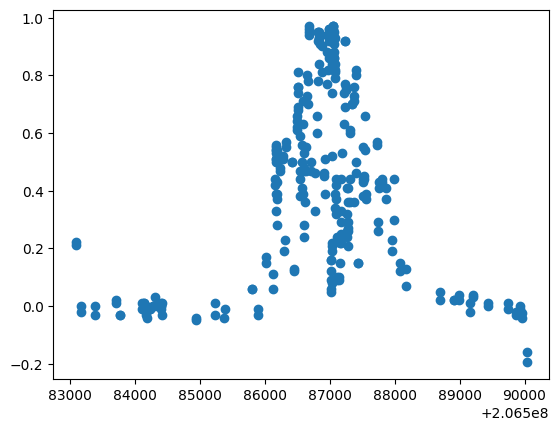

In [79]:
import matplotlib.pyplot as plt
plt.scatter(dmr_df['start'], dmr_df['effect_size'])

<BarContainer object of 286 artists>

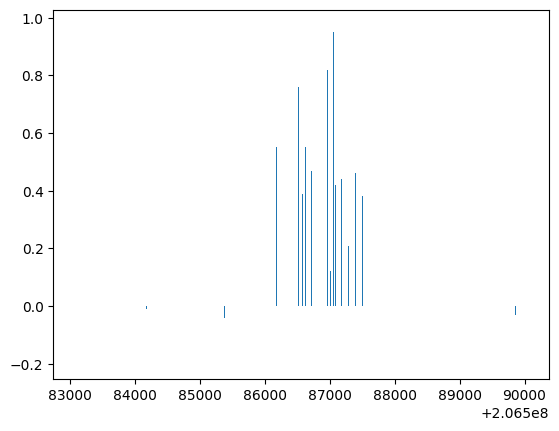

In [80]:
plt.bar(dmr_df['start'], dmr_df['effect_size'])

<BarContainer object of 286 artists>

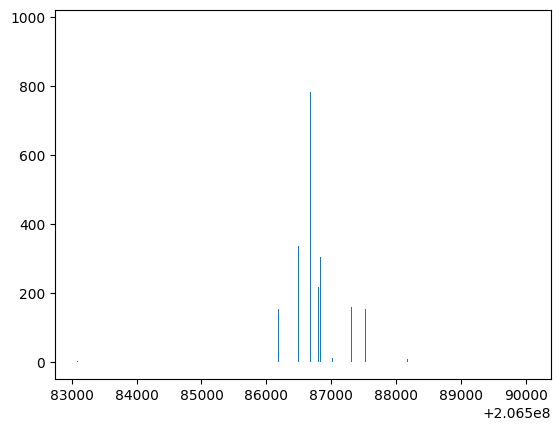

In [82]:
plt.bar(dmr_df['start'], dmr_df['score'])

# Add Hg38 coords by shifting:
-734704

In [103]:
dmr_df['start_hg38']= dmr_df['start'] + 734704
dmr_df['end_hg38']= dmr_df['end'] + 734704
dmr_df['start_t2tv2']= dmr_df['start'] #+ 734704
dmr_df['end_t2tv2']= dmr_df['end'] #+ 734704

In [105]:
dmr_df.columns

Index(['chrom', 'start', 'end', 'name', 'score', 'strand', 'samplea_counts',
       'samplea_total', 'sampleb_counts', 'sampleb_total', 'samplea_percents',
       'sampleb_percents', 'samplea_fraction_modified',
       'sampleb_fraction_modified', 'map_pvalue', 'effect_size', 'cohen_h',
       'cohen_h_low', 'cohen_h_high', 'map_pval_less005', 'map_pval_log10',
       'cg_unit_pair_id', 'cg_unit_pair', 'efsize-score', 'score-efsize',
       'score_scaled', 'score_scaled-efsize', 'efsize-score_scaled',
       'start_hg38', 'end_hg38', 'start_t2tv2', 'end_t2tv2'],
      dtype='object')

In [107]:
dmr_df['cg_unit_pair_id']

0        CG_1.+
1        CG_1.-
2        CG_2.+
3        CG_2.-
4        CG_3.+
         ...   
281    CG_141.-
282    CG_142.+
283    CG_142.-
284    CG_143.+
285    CG_143.-
Name: cg_unit_pair_id, Length: 286, dtype: object

# lable x-ticks

In [121]:
# create CG unit pair ids (and keep the user-typed alias with the typo)
# uses existing notebook variables: dmr_df, np, px, os, out_dir, experiment_codition, pvalue_thresh

# build labels based on sorted genomic position and strand, pairing consecutive entries
order = dmr_df.sort_values(['start', 'strand']).index.to_numpy()
cg_nums = (np.arange(len(order)) // 2) + 1

labels = [None] * len(dmr_df)
for i, orig_idx in enumerate(order):
    strand = dmr_df.at[orig_idx, 'strand']
    labels[orig_idx] = f"CG_{cg_nums[i]}.{strand}"

dmr_df['cg_unit_pair_id'] = labels
# add alias matching the user's requested (typo) name
dmr_df['cg_unit_pait_id'] = dmr_df['cg_unit_pair_id']

# Bar: use cg_unit_pair_id on x-axis
fig_bar_unsorted = px.bar(
    dmr_df,
    x='cg_unit_pair_id',
    y='score',
    color='map_pval_less005',
    title=f"log marginal Likelihood(LML) score & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'score': 'LML', 'cg_unit_pair_id': 'CG unit id', 'map_pval_less005': f'Significant (p <= {pvalue_thresh})'}
)

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520, margin=dict(b=200))
os.makedirs(out_dir, exist_ok=True)
outpath = os.path.join(out_dir, f"dmr_score_by_cg_unit.html")
try:
    fig_bar_unsorted.write_html(outpath, include_plotlyjs='cdn')
    print("Saved plot to:", outpath)
except Exception:
    print("Could not save HTML, displaying inline instead.")
fig_bar_unsorted.show()

Saved plot to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/dmr_score_by_cg_unit.html


In [ ]:


# Bar: use cg_unit_pair_id on x-axis
fig_bar_unsorted = px.bar(
    dmr_df,
    x='start_hg38',
    y='score',
    color='map_pval_less005',
    title=f"log marginal Likelihood(LML) score & p-vals<0.005 for all CGs (n={len(dmr_df)}) <br>{experiment_codition}",
    labels={'score': 'LML', 'cg_unit_pair_id': 'CG unit id', 'map_pval_less005': f'Significant (p <= {pvalue_thresh})'}
)

fig_bar_unsorted.update_layout(xaxis_tickangle=45, height=520, margin=dict(b=200))

fig_bar_unsorted.show()

# Save dmr table

In [100]:
date_today = '20251121'

In [101]:
out_dir


'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/modkit_dmr/mc_07/filtered/new_dmr_output/'

In [102]:
dmr_df.to_csv(os.path.join(out_dir, f'{date_today}_dmr_{experiment_codition}.csv')) # index=False)

# Todo:
- plot the raw pileups together too - next too each other (have the separat individual pileup values plots above from the funcs on top)

-- chech how to look at VARIANCE per CG unit position

# TODO: check
- are there really NO diffs between the reads selected with the mC > 70 and mC > 99.5% filtering ??

could be as the mC calles are automatically selected

and in the CRoff the auto threshold 
* in mC > 70 was to 0.79
> Using filter threshold 0.7910156 for C.
* in mC > 99.5 was to  0.79
> Using filter threshold 0.7910156 for C.


and in the Unediter the auto threshold 
* in mC > 70 was to 0.8496
> Using filter threshold 0.8496094 for C.
* in mC > 99.5 was to 0.849
> Using filter threshold 0.8496094 for C.


SAME per condition AUTOMATIC modkit filtering threshold per mC run were set

(NOT 0.995 and not 0.7)